# Загрузка данных и импорт библиотек

In [68]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from tqdm import tqdm
import os
from google.colab import drive
import string
from pymystem3 import Mystem

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
def load_jsonl(file_path):
  """
  Функция для загрузки json файлов
  """
  data = []
  with open(file_path, 'r', encoding='utf-8') as f:
      for line in f:
          data.append(json.loads(line))
  return data

Загружаем данные из json

In [70]:
file_paths = [
    '/content/drive/MyDrive/data/train.jsonl',
    '/content/drive/MyDrive/data/val.jsonl',
    '/content/drive/MyDrive/data/test.jsonl'
]

train_data = load_jsonl(file_paths[0])
train_dataset = pd.DataFrame(train_data)

val_data = load_jsonl(file_paths[1])
val_dataset = pd.DataFrame(val_data)

test_data = load_jsonl(file_paths[2])
test_dataset = pd.DataFrame(test_data)

In [71]:
print("Train dataset shape:", train_dataset.shape)
print("Validation dataset shape:", val_dataset.shape)
print("Test dataset shape:", test_dataset.shape)

Train dataset shape: (500, 2)
Validation dataset shape: (100, 2)
Test dataset shape: (322, 2)


#Обработка датасета

In [72]:
train_dataset.drop(columns='idx')
val_dataset.drop(columns='idx')
test_dataset.drop(columns='idx')

passage
0    {'text': '"(1) Издательство Viking Press совме...
1    {'text': '"(1) Студия Epic Games анонсировала ...
2    {'text': '"(1) Компания Warner Bros. рассматри...
3    {'text': '(1) На полках лаборатории Лоуренс-Бе...
4    {'text': '(1) Усилия Лэнгдона оказываются напр...
..                                                 ...
317  {'text': '(1) Какое же зеркало жизни наш язык!...
318  {'text': '(1) Россиянин Дмитрий Михайленко ста...
319  {'text': '(1) Датский карикатурист Курт Вестер...
320  {'text': '(1) Жил-был маленький медвежонок. (2...
321  {'text': '"(1) В Латвии вынесен приговор владе...

[322 rows x 1 columns]

In [73]:
def data_parser(data_dict):
    """
    Функция, которая разделяет passage на 3 словаря.
    """
    if isinstance(data_dict, str):
        data_dict = json.loads(data_dict.replace("'", '"'))

    passage_text = data_dict['text'].strip('"')

    parsed_data = {
        'passage_text': passage_text,
        'questions': [],
        'all_answers': []
    }

    for q in data_dict['questions']:
        question_data = {
            'question_id': q['idx'],
            'question_text': q['question'],
            'answers': []
        }

        for a in q['answers']:
            answer_data = {
                'answer_id': a['idx'],
                'answer_text': a['text'],
                'question_id': q['idx']
            }

            if 'label' in a:
                answer_data['label'] = a['label']

            question_data['answers'].append(answer_data)
            parsed_data['all_answers'].append(answer_data)

        parsed_data['questions'].append(question_data)

    return parsed_data

In [74]:
def process_full_dataset(dataset):
    """
    Функция, которая разделяет весь датасет построчно на 3 датасета.
    """
    all_passages = []
    all_questions = []
    all_answers = []

    for index, row in dataset.iterrows():
        parsed_data = data_parser(row['passage'])

        if parsed_data:
            all_passages.append({
                'passage_id': row.get('id', index),
                'passage_text': parsed_data['passage_text']
            })

            for q in parsed_data['questions']:
                q_data = {
                    'passage_id': row.get('id', index),
                    'question_id': q['question_id'],
                    'question_text': q['question_text']
                }
                all_questions.append(q_data)

            for a in parsed_data['all_answers']:
                a_data = {
                    'passage_id': row.get('id', index),
                    'question_id': a['question_id'],
                    'answer_id': a['answer_id'],
                    'answer_text': a['answer_text']
                }

                if 'label' in a:
                    a_data['label'] = a['label']

                all_answers.append(a_data)

    passages_df = pd.DataFrame(all_passages)
    questions_df = pd.DataFrame(all_questions)
    answers_df = pd.DataFrame(all_answers)

    return passages_df, questions_df, answers_df

In [75]:
def join_datasets(passages_df, questions_df, answers_df, include_text=True):
  """
  Функция производящая join датасета
  """
  qa_df = questions_df.merge(
      answers_df,
      on=['passage_id', 'question_id'],
      how='left',
      suffixes=('', '_answer')
  )

  if include_text:
      full_df = qa_df.merge(
          passages_df,
          on='passage_id',
          how='left'
      )
  else:
      temp_passages = passages_df[['passage_id']].copy()
      full_df = qa_df.merge(
          temp_passages,
          on='passage_id',
          how='left'
      )

  return full_df

In [76]:
passages_train, questions_train, answers_train = process_full_dataset(train_dataset)
passages_val, questions_val, answers_val = process_full_dataset(val_dataset)
passages_test, questions_test, answers_test = process_full_dataset(test_dataset)

In [77]:
print(passages_train)

     passage_id                                       passage_text
0             0  (1) Но люди не могут существовать без природы,...
1             1  (1)Образы природы сопровождают людей с самой г...
2             2  (1) Стояло жаркое лето, столько работы вокруг!...
3             3  (1) Российский вратарь клуба НХЛ "Эдмонтон Ойл...
4             4  (1) Председатель Следственного комитета при пр...
..          ...                                                ...
495         495  (1) Наступил сентябрь. (2)Вадим должен был бы ...
496         496  (1) В молодости я считал себя человеком отличн...
497         497  (1) В Новосибирске судья отпустил по амнистии ...
498         498  (1) Каспийская флотилия, оперативное объединен...
499         499  (1) Известный американский боец смешанных един...

[500 rows x 2 columns]


In [78]:
print(questions_train)

      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
2892         498         2892   
2893         499         2893   
2894         499         2894   
2895         499         2895   
2896         499         2896   

                                          question_text  
0                                     Где бегала шпана?  
1                           Почему Люда ударила Артема?  
2                      Как развлекались в парке ребята?  
3     Что происходило, когда Людочка бралась подстри...  
4          Какие волосы росли на голове у Артемки-мыла?  
...                                                 ...  
2892  Как назван корабль, спущенный на воду в начале...  
2893                 Чем Монсона так привлекает Россия?  
2894             Почему так много татуировок у Монсона?  
2895               Скол

In [79]:
print(answers_train)

       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  
0                                               В парке.      1  
1                                                В лесу.      0  
2                                        Около подъезда.      0  
3                                    Он к ней приставал.      1  
4                                        Он ее оскорбил.      0  
...                                                  ...    ...

# Анализ Данных

## Анализ текстов документов

In [80]:
!pip install nltk

In [81]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer


In [82]:
nltk.download('punkt')
nltk.download('punkt_tab')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [83]:
def clean_text(text):
    """Очищает текст от знаков препинания и приводит к нижнему регистру"""
    text = re.sub(r'\(\d+\)', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [84]:
def lemmatize_text(text):
    """Лемматизирует текст, приводя слова к начальной форме"""
    mystem = Mystem()
    lemmas = mystem.lemmatize(text)
    return ''.join(lemmas).strip()

In [85]:
russian_stopwords = ['и', 'в', 'на', 'с', 'по', 'к', 'у', 'о', 'из', 'от', 'для', 'во', 'за',
                      'что', 'кто', 'как', 'где', 'когда', 'почему', 'чем', 'этот', 'тот',
                      'такой', 'который', 'весь', 'мой', 'наш', 'ваш', 'их', 'его', 'её',
                      'а', 'но', 'да', 'или', 'ли', 'если', 'бы', 'же', 'ни', 'чтобы', 'чтоб',
                      'только', 'даже', 'около', 'они', 'мы', 'вы', 'ты', 'он', 'она', 'оно',
                      'был', 'была', 'были', 'было', 'быть', 'есть', 'будет', 'буду', 'будем',
                      'при', 'через', 'над', 'под', 'между', 'про', 'до', 'без', 'всё', 'всех',
                      'всем', 'вся', 'кроме', 'ещё', 'также', 'так', 'же', 'одного', 'неё']

### Анализ длины текстов

In [86]:
def text_len_analizator(df):
    """Анализирует распределение длины текстов"""
    df['word_count'] = df['passage_text'].apply(lambda x: len(word_tokenize(x, language='russian')))

    df['sentence_count'] = df['passage_text'].apply(lambda x: len(sent_tokenize(x, language='russian')))

    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']

    print(f"Медианное количество слов: {df['word_count'].median()}")
    print(f"Минимальное количество слов: {df['word_count'].min()}")
    print(f"Максимальное количество слов: {df['word_count'].max()}")

    print(f"Медианное количество предложений: {df['sentence_count'].median()}")
    print(f"Минимальное количество предложений: {df['sentence_count'].min()}")
    print(f"Максимальное количество предложений: {df['sentence_count'].max()}")

    print(f"Средняя длина предложения (в словах): {df['avg_sentence_length'].mean():.2f}\n\n\n")


    plt.figure(figsize=(7, 5))
    sns.histplot(df['word_count'], kde=True)
    plt.title('Распределение количества слов в текстах')
    plt.xlabel('Количество слов')
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.histplot(df['sentence_count'], kde=True)
    plt.title('Распределение количества предложений в текстах')
    plt.xlabel('Количество предложений')
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.histplot(df['avg_sentence_length'], kde=True)
    plt.title('Распределение средней длины предложения')
    plt.xlabel('Средняя длина предложения (в словах)')
    plt.ylabel('Частота')
    plt.show()

    return df

#### Train

Медианное количество слов: 263.0
Минимальное количество слов: 150
Максимальное количество слов: 683
Медианное количество предложений: 14.0
Минимальное количество предложений: 7
Максимальное количество предложений: 23
Средняя длина предложения (в словах): 20.32





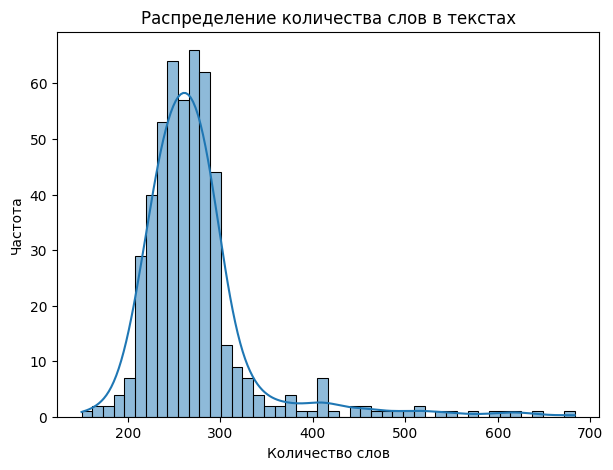

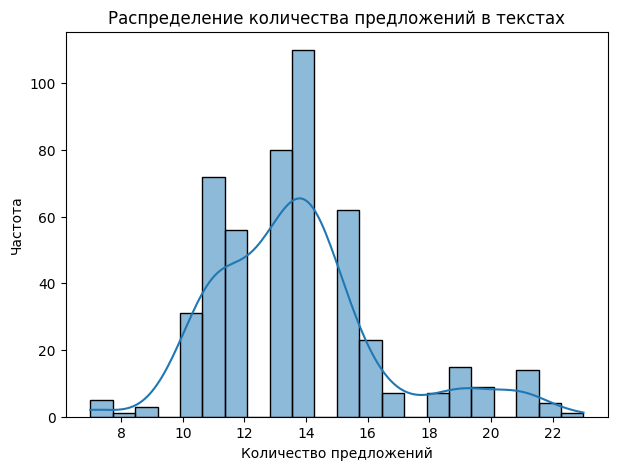

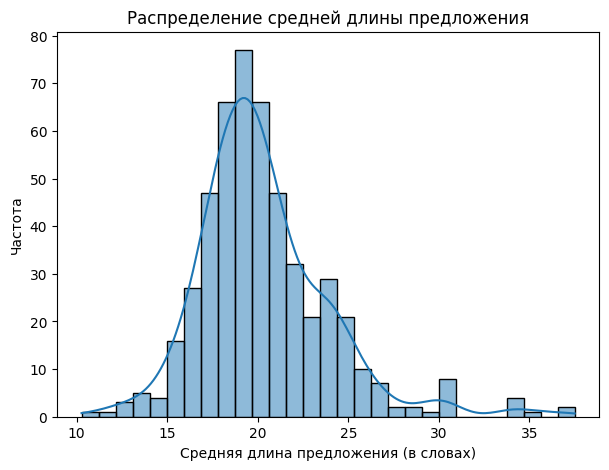

     passage_id                                       passage_text  \
0             0  (1) Но люди не могут существовать без природы,...   
1             1  (1)Образы природы сопровождают людей с самой г...   
2             2  (1) Стояло жаркое лето, столько работы вокруг!...   
3             3  (1) Российский вратарь клуба НХЛ "Эдмонтон Ойл...   
4             4  (1) Председатель Следственного комитета при пр...   
..          ...                                                ...   
495         495  (1) Наступил сентябрь. (2)Вадим должен был бы ...   
496         496  (1) В молодости я считал себя человеком отличн...   
497         497  (1) В Новосибирске судья отпустил по амнистии ...   
498         498  (1) Каспийская флотилия, оперативное объединен...   
499         499  (1) Известный американский боец смешанных един...   

     word_count  sentence_count  avg_sentence_length  
0           234              10            23.400000  
1           392              16            24.500

In [87]:
print(text_len_analizator(passages_train))

#### Val

Медианное количество слов: 266.0
Минимальное количество слов: 197
Максимальное количество слов: 691
Медианное количество предложений: 14.0
Минимальное количество предложений: 9
Максимальное количество предложений: 24
Средняя длина предложения (в словах): 20.16





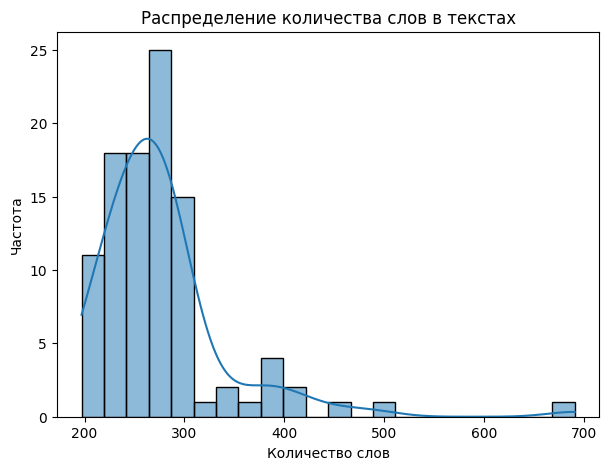

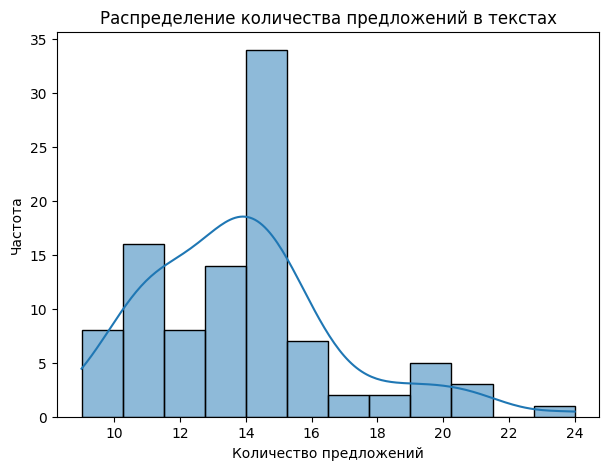

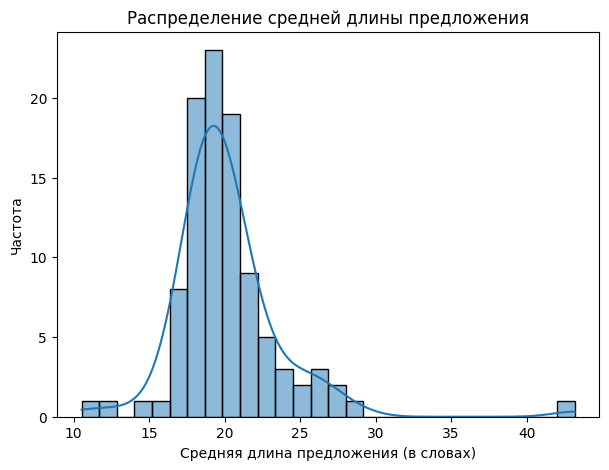

    passage_id                                       passage_text  word_count  \
0            0  (1) Самый первый «остров» Архипелага возник в ...         207   
1            1  (1) Сбербанк обратился в Арбитражный суд Санкт...         289   
2            2  (1)Стала она слепнуть. (2)Текст расплывается п...         454   
3            3  (1)Над письменным столом висит фотография отца...         381   
4            4  (1) Казанский "Рубин" одержал домашнюю победу ...         274   
..         ...                                                ...         ...   
95          95  (1) Американский кабельный канал AMC продлил з...         265   
96          96  (1) Джеймс Франко снимется в полнометражной ле...         297   
97          97  (1) Приквел Ридли Скота к фильму "Чужой" будет...         279   
98          98  (1) На Украине собираются поднять со дна Черно...         253   
99          99  (1) Канадский порноактер Лука Рокко Маньотта, ...         247   

    sentence_count  avg_sen

In [88]:
print(text_len_analizator(passages_val))

#### Test

Медианное количество слов: 264.0
Минимальное количество слов: 127
Максимальное количество слов: 547
Медианное количество предложений: 13.0
Минимальное количество предложений: 6
Максимальное количество предложений: 22
Средняя длина предложения (в словах): 20.37





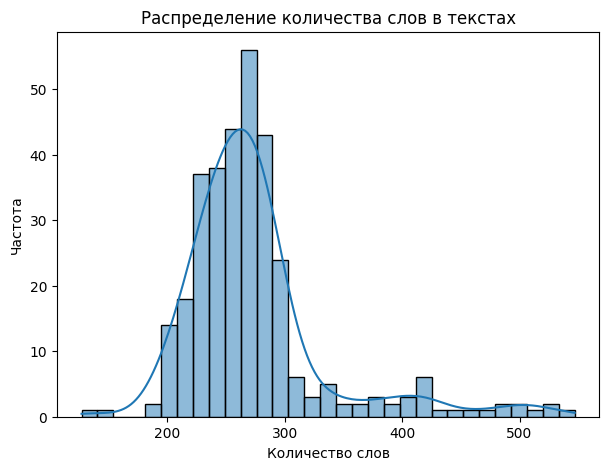

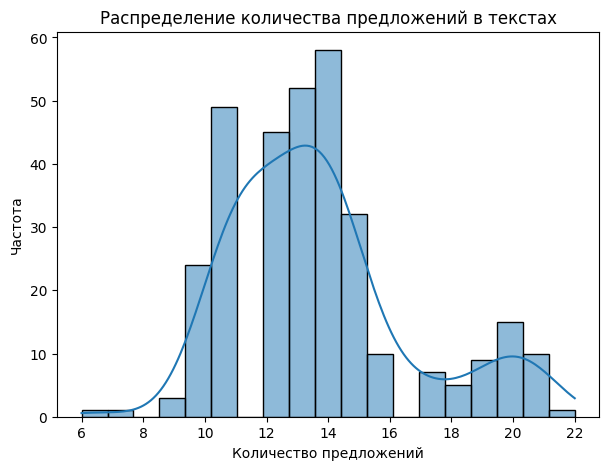

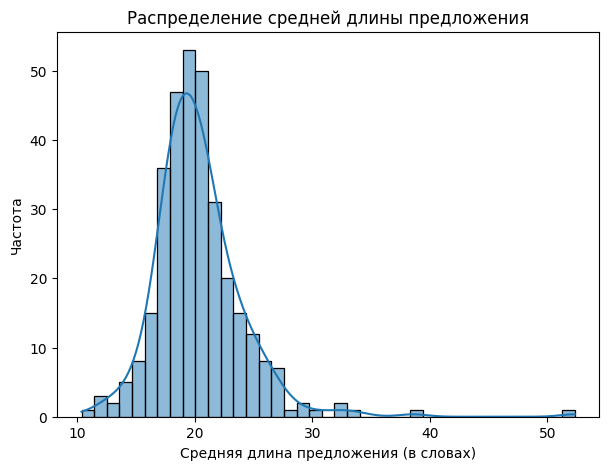

     passage_id                                       passage_text  \
0             0  (1) Издательство Viking Press совместно с комп...   
1             1  (1) Студия Epic Games анонсировала бета-тест ш...   
2             2  (1) Компания Warner Bros. рассматривает Бена А...   
3             3  (1) На полках лаборатории Лоуренс-Беркли нашли...   
4             4  (1) Усилия Лэнгдона оказываются напрасными: ме...   
..          ...                                                ...   
317         317  (1) Какое же зеркало жизни наш язык!(2) Нет, о...   
318         318  (1) Россиянин Дмитрий Михайленко стал обладате...   
319         319  (1) Датский карикатурист Курт Вестергор заявил...   
320         320  (1) Жил-был маленький медвежонок. (2) У него б...   
321         321  (1) В Латвии вынесен приговор владельцу модель...   

     word_count  sentence_count  avg_sentence_length  
0           282              15            18.800000  
1           219              12            18.250

In [89]:
print(text_len_analizator(passages_test))

После анализа длины текстов документов можно сказать, что

медианное количество слов 264,

средняя длина предложения 20 слов,

количество предложений в текстах не превышает 24.

Также по графикам можно увидеть, что в основном распределения количества слов в предложении, количества предложений в тексте и средней длины предложения являются нормальными. А значит нам будет легче использовать данные при обучении модели.


### Анализ частоты слов

In [90]:
def freq_word_analizator(df, top_n=50):

    def simple_tokenize(text):
        return text.split()
    additional_stopwords = ['был', 'была', 'были', 'было', 'быть', 'это', 'эти', 'этих',
                           'так', 'же', 'не', 'тебя', 'меня', 'при','всё','ещё',
                          'который', 'однако','которые','которого','которой','которая',
                            'изза', 'около', 'также', 'кроме','одного','неё']
    all_stopwords = set(russian_stopwords + additional_stopwords)

    cleaned_texts = df['passage_text'].apply(clean_text)

    all_words = []
    for text in cleaned_texts:
        words = simple_tokenize(text)
        all_words.extend(words)

    filtered_words = [word for word in all_words if word not in all_stopwords and len(word) > 2]

    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(top_n)

    print(f"Всего уникальных слов после фильтрации: {len(word_freq)}")
    print(f"\nТоп-{top_n} наиболее часто встречающихся слов в текстах документов:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")

    plt.figure(figsize=(11, 8))
    words, freqs = zip(*most_common_words)
    plt.barh(words, freqs, color='skyblue')
    plt.title(f'Топ-{top_n} наиболее часто встречающихся слов в текстах')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.tight_layout()
    plt.show()

    return most_common_words

#### Train

Всего уникальных слов после фильтрации: 28846

Топ-50 наиболее часто встречающихся слов в текстах документов:
года: 271
этом: 229
после: 191
сообщает: 183
время: 180
уже: 179
ему: 172
году: 171
все: 157
того: 125
том: 121
может: 119
человек: 115
него: 106
этого: 104
россии: 104
своей: 102
себя: 101
один: 95
заявил: 95
свою: 85
нет: 85
словам: 82
жизни: 80
лет: 79
них: 79
раз: 79
несколько: 78
более: 77
теперь: 76
стал: 75
пока: 74
очень: 73
себе: 73
тем: 72
своего: 70
жизнь: 69
перед: 69
всего: 68
ранее: 66
день: 66
тысяч: 66
мне: 65
сам: 65
больше: 64
вот: 63
сказал: 62
является: 62
сша: 62
the: 61


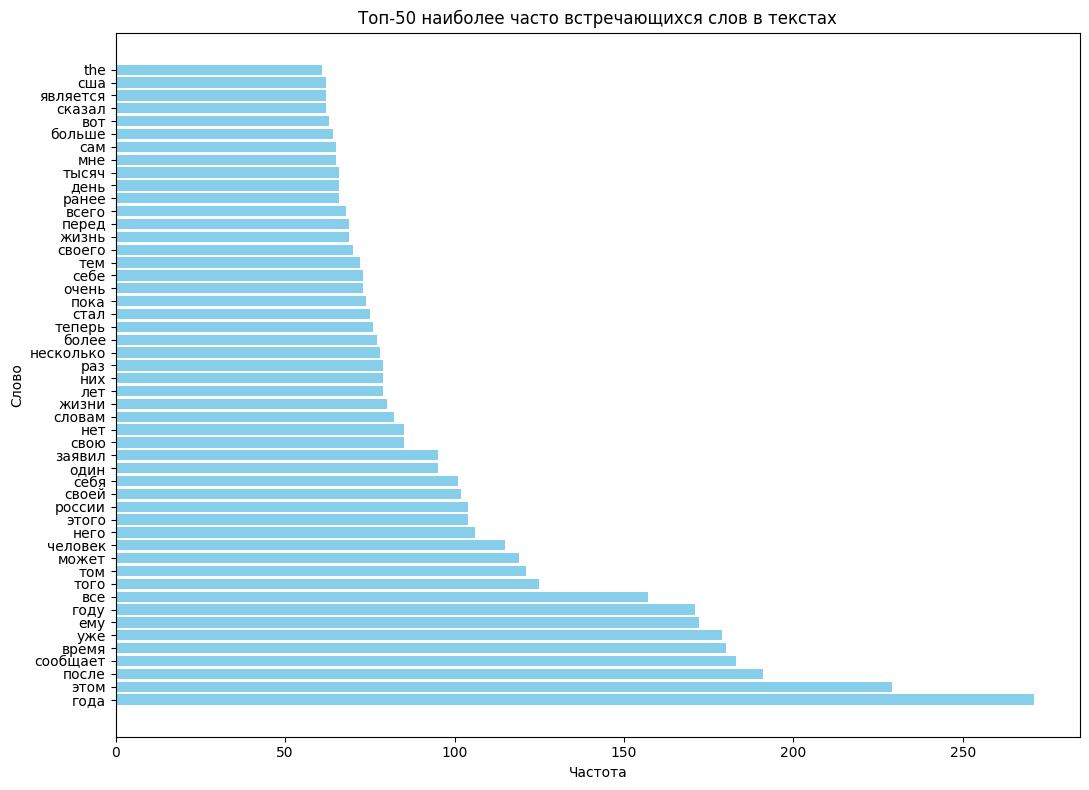

[('года', 271), ('этом', 229), ('после', 191), ('сообщает', 183), ('время', 180), ('уже', 179), ('ему', 172), ('году', 171), ('все', 157), ('того', 125), ('том', 121), ('может', 119), ('человек', 115), ('него', 106), ('этого', 104), ('россии', 104), ('своей', 102), ('себя', 101), ('один', 95), ('заявил', 95), ('свою', 85), ('нет', 85), ('словам', 82), ('жизни', 80), ('лет', 79), ('них', 79), ('раз', 79), ('несколько', 78), ('более', 77), ('теперь', 76), ('стал', 75), ('пока', 74), ('очень', 73), ('себе', 73), ('тем', 72), ('своего', 70), ('жизнь', 69), ('перед', 69), ('всего', 68), ('ранее', 66), ('день', 66), ('тысяч', 66), ('мне', 65), ('сам', 65), ('больше', 64), ('вот', 63), ('сказал', 62), ('является', 62), ('сша', 62), ('the', 61)]


In [91]:
print(freq_word_analizator(passages_train))

#### Val

Всего уникальных слов после фильтрации: 8354

Топ-50 наиболее часто встречающихся слов в текстах документов:
года: 71
году: 47
все: 47
этом: 42
после: 38
время: 38
ему: 30
себя: 28
уже: 26
сообщает: 25
того: 22
него: 20
может: 20
человек: 20
рублей: 19
перед: 19
лет: 19
том: 19
пока: 18
раз: 18
является: 17
один: 17
заявил: 17
тем: 17
россии: 16
теперь: 16
нет: 16
апреля: 16
всего: 15
суд: 15
компании: 15
несколько: 15
своей: 15
своих: 14
ней: 14
этого: 14
словам: 14
три: 14
2011: 14
первый: 13
более: 13
тут: 13
себе: 13
стал: 13
много: 13
мать: 13
свою: 13
news: 13
мира: 13
получил: 13


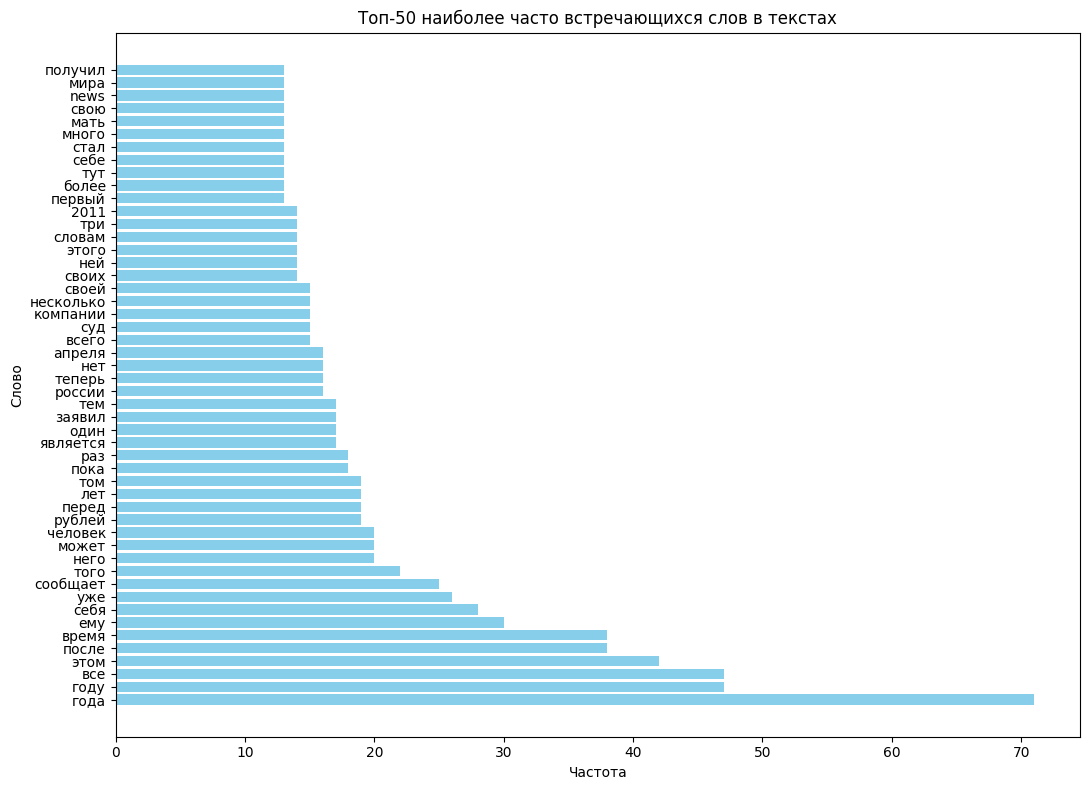

[('года', 71), ('году', 47), ('все', 47), ('этом', 42), ('после', 38), ('время', 38), ('ему', 30), ('себя', 28), ('уже', 26), ('сообщает', 25), ('того', 22), ('него', 20), ('может', 20), ('человек', 20), ('рублей', 19), ('перед', 19), ('лет', 19), ('том', 19), ('пока', 18), ('раз', 18), ('является', 17), ('один', 17), ('заявил', 17), ('тем', 17), ('россии', 16), ('теперь', 16), ('нет', 16), ('апреля', 16), ('всего', 15), ('суд', 15), ('компании', 15), ('несколько', 15), ('своей', 15), ('своих', 14), ('ней', 14), ('этого', 14), ('словам', 14), ('три', 14), ('2011', 14), ('первый', 13), ('более', 13), ('тут', 13), ('себе', 13), ('стал', 13), ('много', 13), ('мать', 13), ('свою', 13), ('news', 13), ('мира', 13), ('получил', 13)]


In [92]:
print(freq_word_analizator(passages_val))

#### Test

Всего уникальных слов после фильтрации: 20761

Топ-50 наиболее часто встречающихся слов в текстах документов:
года: 144
этом: 137
все: 133
после: 116
уже: 115
время: 114
ему: 109
сообщает: 100
того: 91
мне: 90
году: 87
человек: 80
может: 74
этого: 72
него: 71
том: 70
очень: 63
себя: 62
них: 62
своей: 61
свою: 58
себе: 57
словам: 56
россии: 54
теперь: 54
раз: 54
несколько: 53
заявил: 51
жизни: 48
там: 47
стал: 47
лет: 47
вот: 44
больше: 43
тем: 43
один: 42
жизнь: 41
более: 41
пока: 41
нет: 41
нас: 41
ним: 40
сам: 40
сказал: 40
двух: 39
своих: 38
перед: 38
можно: 38
дома: 37
человека: 37


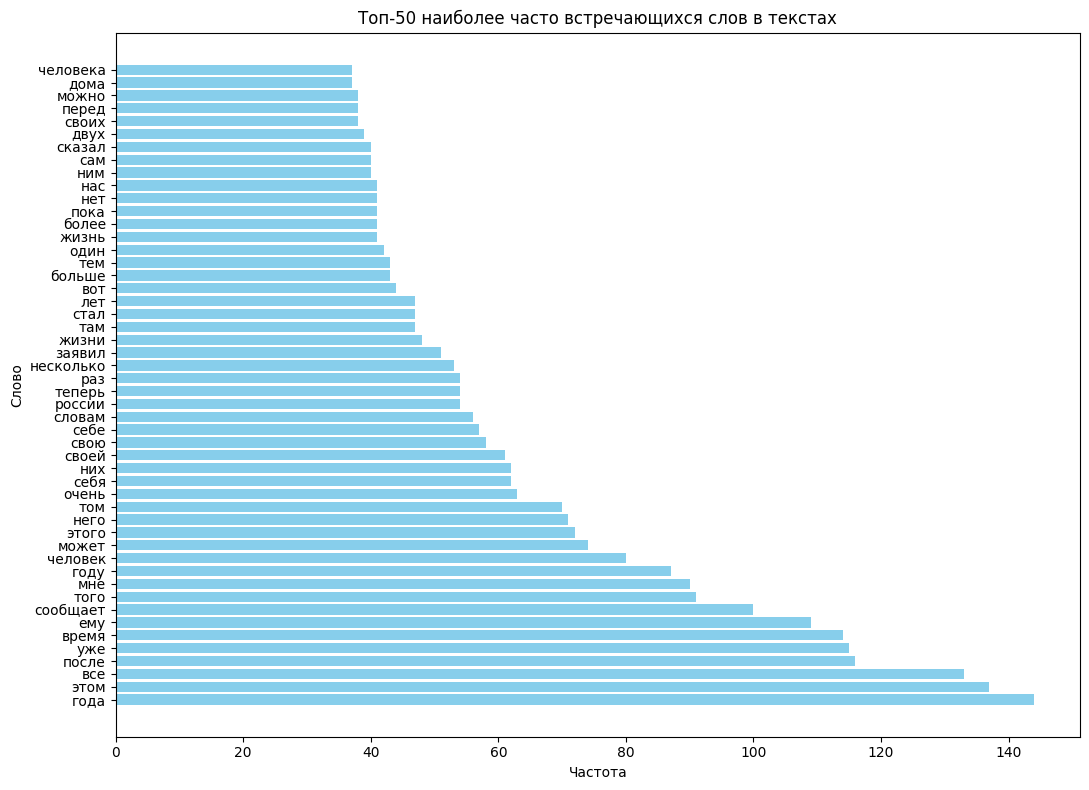

[('года', 144), ('этом', 137), ('все', 133), ('после', 116), ('уже', 115), ('время', 114), ('ему', 109), ('сообщает', 100), ('того', 91), ('мне', 90), ('году', 87), ('человек', 80), ('может', 74), ('этого', 72), ('него', 71), ('том', 70), ('очень', 63), ('себя', 62), ('них', 62), ('своей', 61), ('свою', 58), ('себе', 57), ('словам', 56), ('россии', 54), ('теперь', 54), ('раз', 54), ('несколько', 53), ('заявил', 51), ('жизни', 48), ('там', 47), ('стал', 47), ('лет', 47), ('вот', 44), ('больше', 43), ('тем', 43), ('один', 42), ('жизнь', 41), ('более', 41), ('пока', 41), ('нет', 41), ('нас', 41), ('ним', 40), ('сам', 40), ('сказал', 40), ('двух', 39), ('своих', 38), ('перед', 38), ('можно', 38), ('дома', 37), ('человека', 37)]


In [93]:
print(freq_word_analizator(passages_test))

После анализа частоты слов, можно сказать, что самым частым словом является слово год, в разных варициях (года, году), также довольно частые слова: лет, время.

А это значит, что тексты имеют хронологическую составляющую, поэтому нам нужно уделить больше внимания к обработке временных контекстов при обучении нашей модели.

### Анализ типов предложений

In [94]:
def types_analizator(df):
    sentence_types = {
        'declarative': 0,
        'interrogative': 0,
        'exclamatory': 0,
        'other': 0
    }

    total_sentences = 0

    for text in df['passage_text']:
        sentences = sent_tokenize(text, language='russian')
        total_sentences += len(sentences)

        for sentence in sentences:
            sentence = sentence.strip()
            if sentence.endswith('?'):
                sentence_types['interrogative'] += 1
            elif sentence.endswith('!'):
                sentence_types['exclamatory'] += 1
            elif sentence.endswith('.'):
                sentence_types['declarative'] += 1
            else:
                sentence_types['other'] += 1

    percentages = {
        type_name: (count / total_sentences) * 100
        for type_name, count in sentence_types.items()
    }

    print("\nТипы предложений по знакам препинания:")
    print(f"Всего предложений: {total_sentences}")
    for type_name, count in sentence_types.items():
        print(f"{type_name}: {count} ({percentages[type_name]:.2f}%)")

    plt.figure(figsize=(10, 6))
    plt.bar(sentence_types.keys(), sentence_types.values())
    plt.title('Распределение типов предложений')
    plt.xlabel('Тип предложения')
    plt.ylabel('Количество')
    plt.show()

    return sentence_types, percentages

#### Train


Типы предложений по знакам препинания:
Всего предложений: 6837
declarative: 6453 (94.38%)
interrogative: 118 (1.73%)
exclamatory: 174 (2.54%)
other: 92 (1.35%)


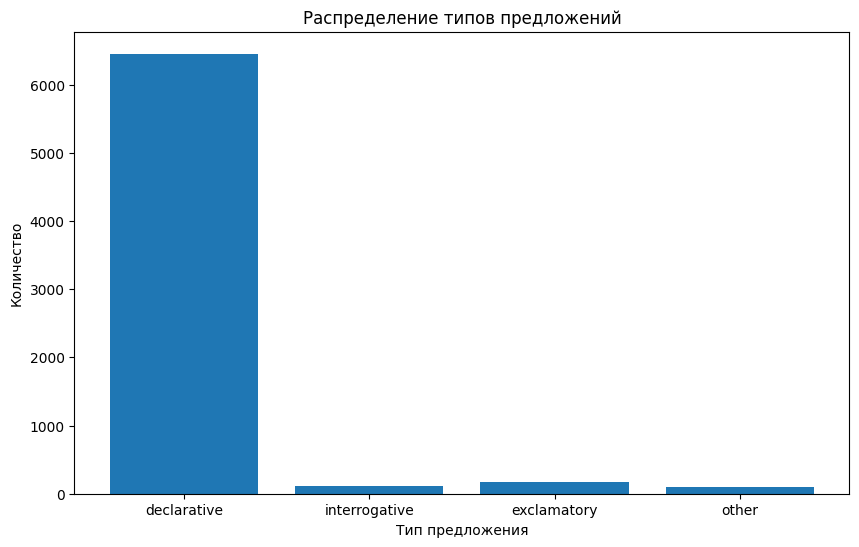

({'declarative': 6453, 'interrogative': 118, 'exclamatory': 174, 'other': 92}, {'declarative': 94.3835015357613, 'interrogative': 1.7259031739066844, 'exclamatory': 2.5449758666081617, 'other': 1.3456194237238555})


In [95]:
print(types_analizator(passages_train))

#### Val


Типы предложений по знакам препинания:
Всего предложений: 1388
declarative: 1310 (94.38%)
interrogative: 32 (2.31%)
exclamatory: 28 (2.02%)
other: 18 (1.30%)


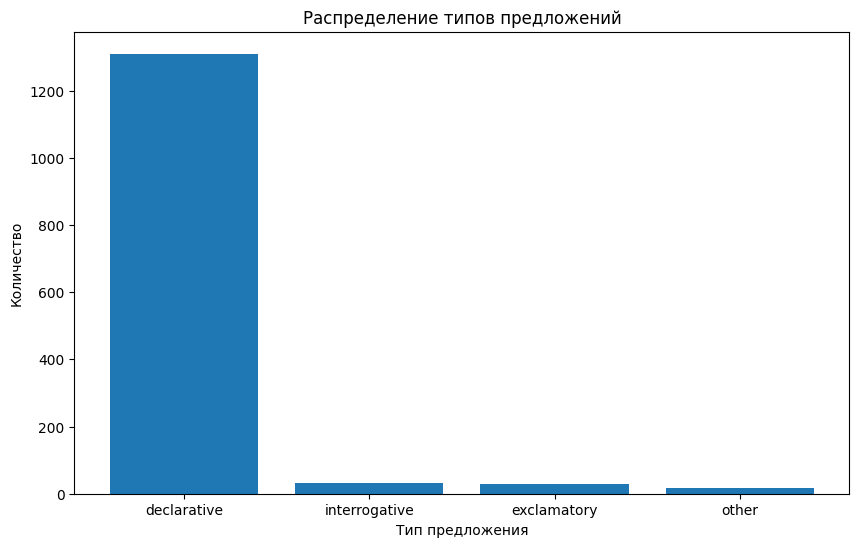

({'declarative': 1310, 'interrogative': 32, 'exclamatory': 28, 'other': 18}, {'declarative': 94.38040345821325, 'interrogative': 2.3054755043227666, 'exclamatory': 2.0172910662824206, 'other': 1.2968299711815563})


In [96]:
print(types_analizator(passages_val))

#### Test


Типы предложений по знакам препинания:
Всего предложений: 4399
declarative: 4132 (93.93%)
interrogative: 117 (2.66%)
exclamatory: 96 (2.18%)
other: 54 (1.23%)


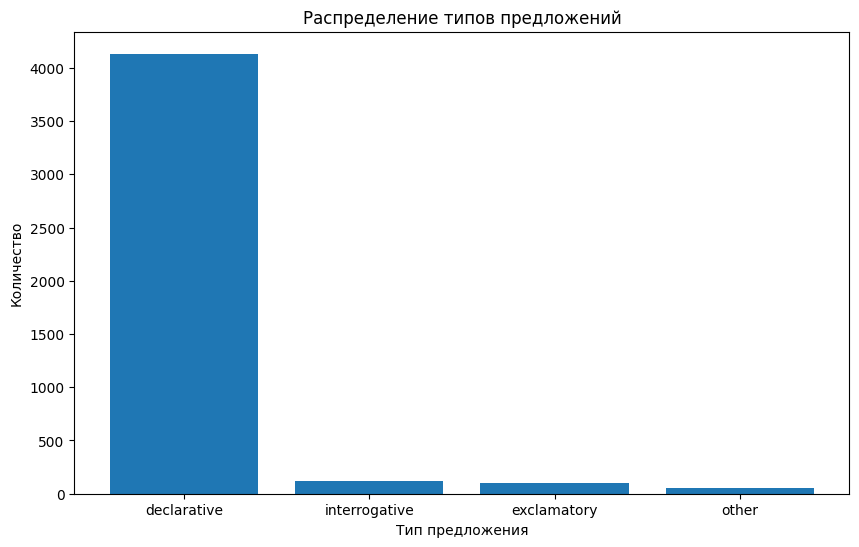

({'declarative': 4132, 'interrogative': 117, 'exclamatory': 96, 'other': 54}, {'declarative': 93.93043873607638, 'interrogative': 2.659695385314844, 'exclamatory': 2.182314162309616, 'other': 1.227551716299159})


In [97]:
print(types_analizator(passages_test))

Больше 90% всех предложений повествовательные. Что говорит о том что тексты имеют информационный характер, а не диалогический. Поэтому наша модель должна будет находить ответы в плотном повествовательном тексте, а не в явно выраженных вопросах.

## Анализ вопросов

### Анализ длины вопросов

In [98]:
def q_len_analizator(df):
    """
    Анализирует распределение длины вопросов
    """
    df['question_word_count'] = df['question_text'].apply(lambda x: len(x.split()))

    df['question_char_count'] = df['question_text'].apply(len)

    print("Статистика длины вопросов:")

    print(f"Медианное количество слов: {df['question_word_count'].median()}")
    print(f"Минимальное количество слов: {df['question_word_count'].min()}")
    print(f"Максимальное количество слов: {df['question_word_count'].max()}\n")


    print(f"Медианное количество символов: {df['question_char_count'].median()}")
    print(f"Минимальное количество символов: {df['question_char_count'].min()}")
    print(f"Максимальное количество символов: {df['question_char_count'].max()}")


    plt.figure(figsize=(10, 6))
    sns.histplot(df['question_word_count'], kde=True)
    plt.title('Распределение количества слов в вопросах')
    plt.xlabel('Количество слов')
    plt.ylabel('Частота')
    plt.show()


    plt.figure(figsize=(10, 6))
    sns.histplot(df['question_char_count'], kde=True)
    plt.title('Распределение количества символов в вопросах')
    plt.xlabel('Количество символов')
    plt.ylabel('Частота')
    plt.show()

    return df

#### Train

Статистика длины вопросов:
Медианное количество слов: 7.0
Минимальное количество слов: 2
Максимальное количество слов: 27

Медианное количество символов: 48.0
Минимальное количество символов: 8
Максимальное количество символов: 220


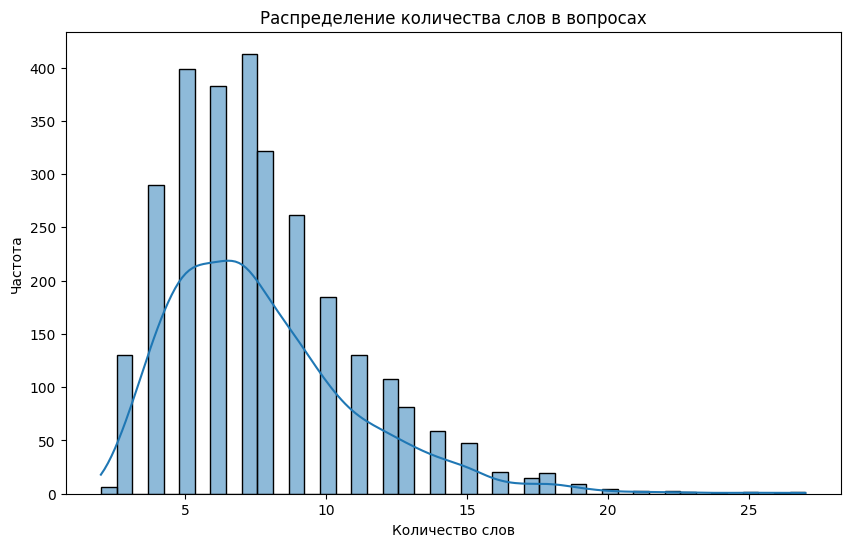

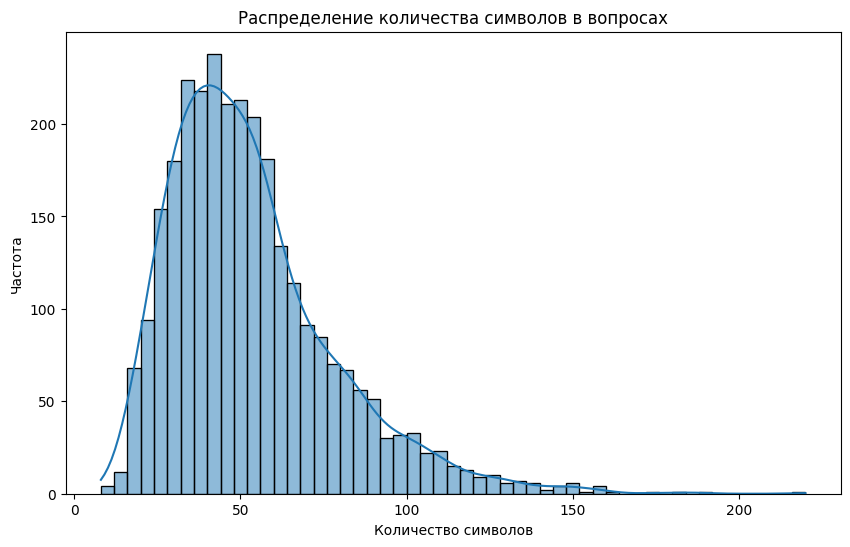

      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
2892         498         2892   
2893         499         2893   
2894         499         2894   
2895         499         2895   
2896         499         2896   

                                          question_text  question_word_count  \
0                                     Где бегала шпана?                    3   
1                           Почему Люда ударила Артема?                    4   
2                      Как развлекались в парке ребята?                    5   
3     Что происходило, когда Людочка бралась подстри...                    7   
4          Какие волосы росли на голове у Артемки-мыла?                    7   
...                                                 ...                  ...   
2892  Как назван корабль, спущенный на воду

In [99]:
print(q_len_analizator(questions_train))

#### Val

Статистика длины вопросов:
Медианное количество слов: 7.0
Минимальное количество слов: 1
Максимальное количество слов: 42

Медианное количество символов: 48.0
Минимальное количество символов: 12
Максимальное количество символов: 287


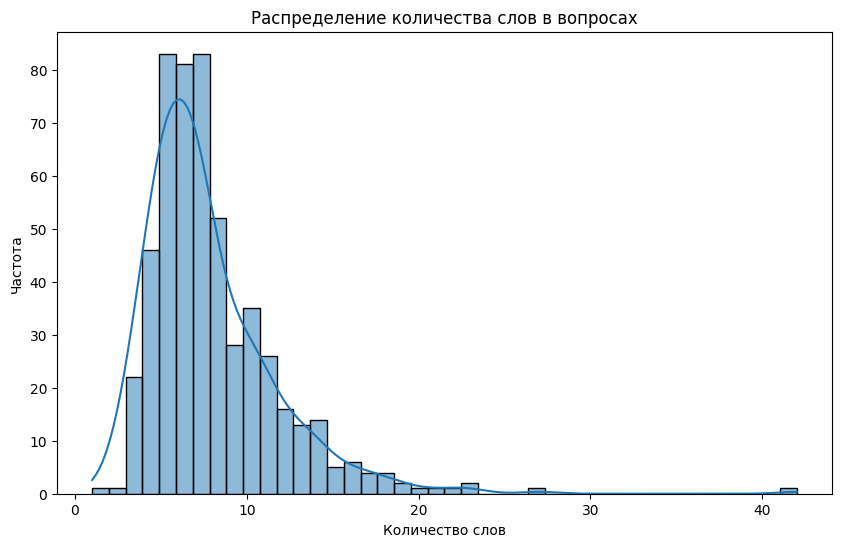

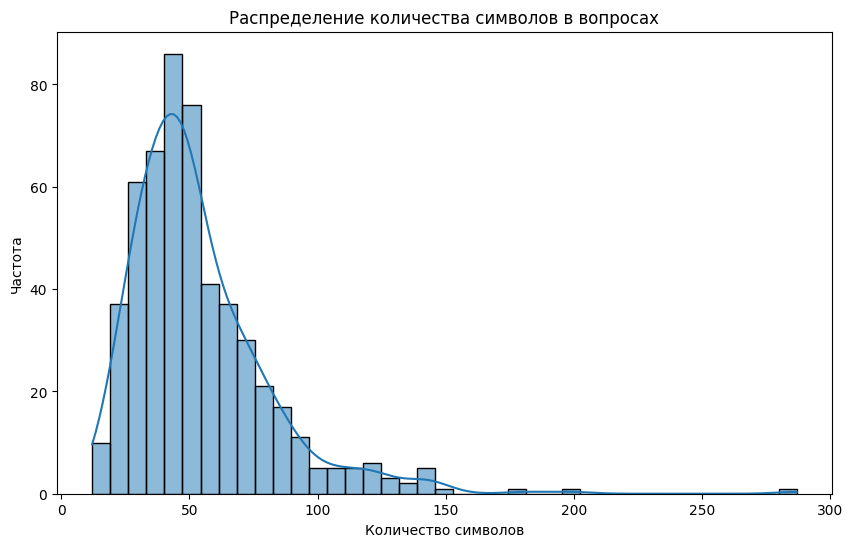

     passage_id  question_id  \
0             0            0   
1             0            1   
2             1            2   
3             1            3   
4             2            4   
..          ...          ...   
524          99          524   
525          99          525   
526          99          526   
527          99          527   
528          99          528   

                                         question_text  question_word_count  \
0           Почему Солженицына перевозили спецконвоем?                    4   
1    Как люди попадали в тюрьмы особого типа на Сол...                    9   
2                   Кто в ноябре подал иск в арбитраж?                    7   
3    Когда было зарегистрировано обращения Сбербанк...                    8   
4                                  Кто начал слепнуть?                    3   
..                                                 ...                  ...   
524  Где был задержан Лукка Рокко Маньотта в связи ...        

In [100]:
print(q_len_analizator(questions_val))

#### Test

Статистика длины вопросов:
Медианное количество слов: 7.0
Минимальное количество слов: 2
Максимальное количество слов: 30

Медианное количество символов: 46.0
Минимальное количество символов: 10
Максимальное количество символов: 185


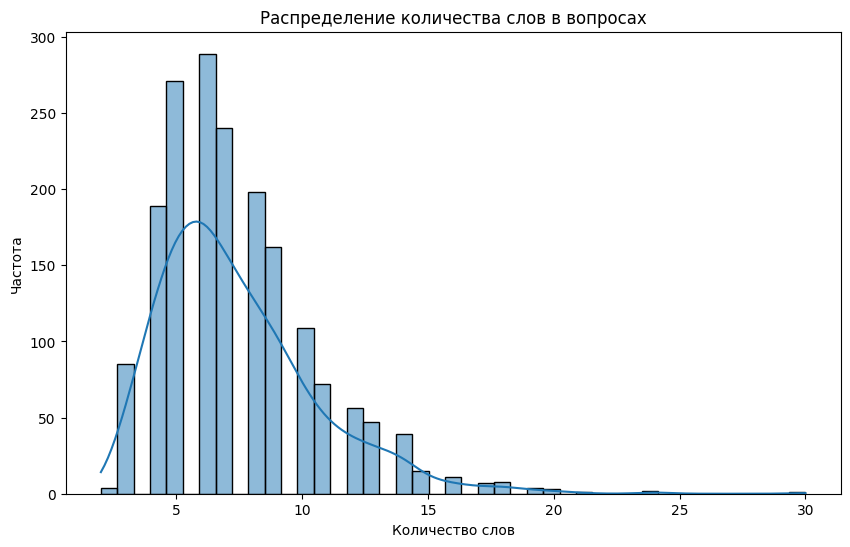

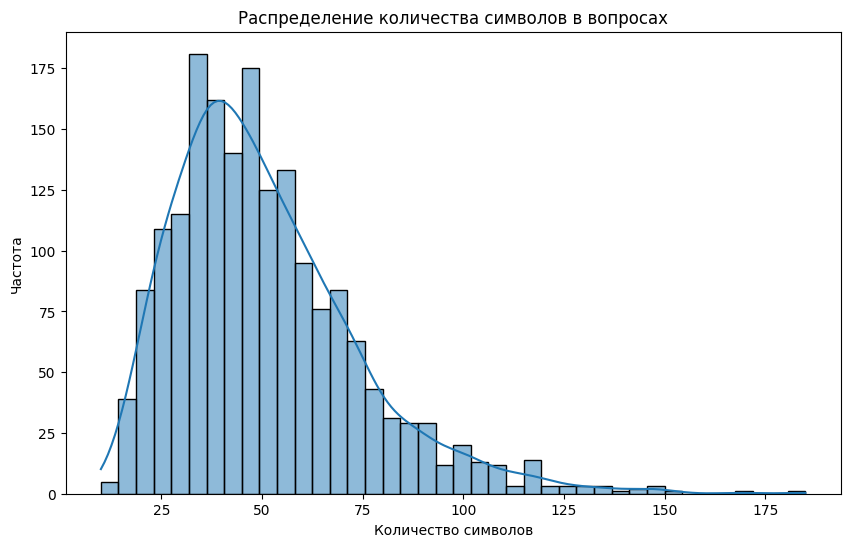

      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
1808         320         1808   
1809         320         1809   
1810         320         1810   
1811         321         1811   
1812         321         1812   

                                          question_text  question_word_count  \
0                             О чем дневник Анны Франк?                    5   
1                Каким будет приложение Anne Frank App?                    6   
2     Какая информация войдет в новой мобильное прил...                    7   
3      Где скрывались члены семьи Франк и другие евреи?                    8   
4     Как Анна называла место, где она и ее семья ск...                   12   
...                                                 ...                  ...   
1808              Почему медвежонок решил у

In [101]:
print(q_len_analizator(questions_test))

### Анализ типов вопросов

In [102]:
def q_types_analizator(df):
    """
    Анализирует типы вопросов по месту, времени, причине, процессу и т.д.
    """
    def classify_question(question):
        question = question.lower()

        if re.match(r'^кто\b|^у кого\b', question):
            return 'Кто'
        elif re.match(r'^что\b|^о ч[её]м\b', question):
            return 'Что'
        elif re.match(r'^где\b|^куда\b|^откуда\b', question):
            return 'Где'
        elif re.match(r'^когда\b', question):
            return 'Когда'
        elif re.match(r'^почему\b|^отчего\b|^зачем\b', question):
            return 'Почему'
        elif re.match(r'^как\b|^каким образом\b', question):
            return 'Как'
        elif re.match(r'^сколько\b', question):
            return 'Сколько'
        elif re.match(r'^какой\b|^какая\b|^какое\b|^какие\b|^каков\b', question):
            return 'Какой'
        elif re.match(r'^чей\b|^чья\b|^чьё\b|^чьи\b', question):
            return 'Чей'
        else:
            return 'Другое'

    df['question_type'] = df['question_text'].apply(classify_question)

    type_counts = df['question_type'].value_counts()
    type_percentages = (type_counts / len(df) * 100).round(2)


    print("Распределение типов вопросов:")
    for q_type, count in type_counts.items():
        percentage = type_percentages[q_type]
        print(f"{q_type}: {count} ({percentage}%)")


    plt.figure(figsize=(12, 6))
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('Распределение типов вопросов')
    plt.xlabel('Тип вопроса')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%')
    plt.title('Процентное соотношение типов вопросов')
    plt.tight_layout()
    plt.show()

    return df, type_counts

#### Train

Распределение типов вопросов:
Другое: 1008 (34.79%)
Что: 484 (16.71%)
Кто: 339 (11.7%)
Какой: 276 (9.53%)
Как: 240 (8.28%)
Почему: 175 (6.04%)
Где: 132 (4.56%)
Сколько: 121 (4.18%)
Когда: 96 (3.31%)
Чей: 26 (0.9%)


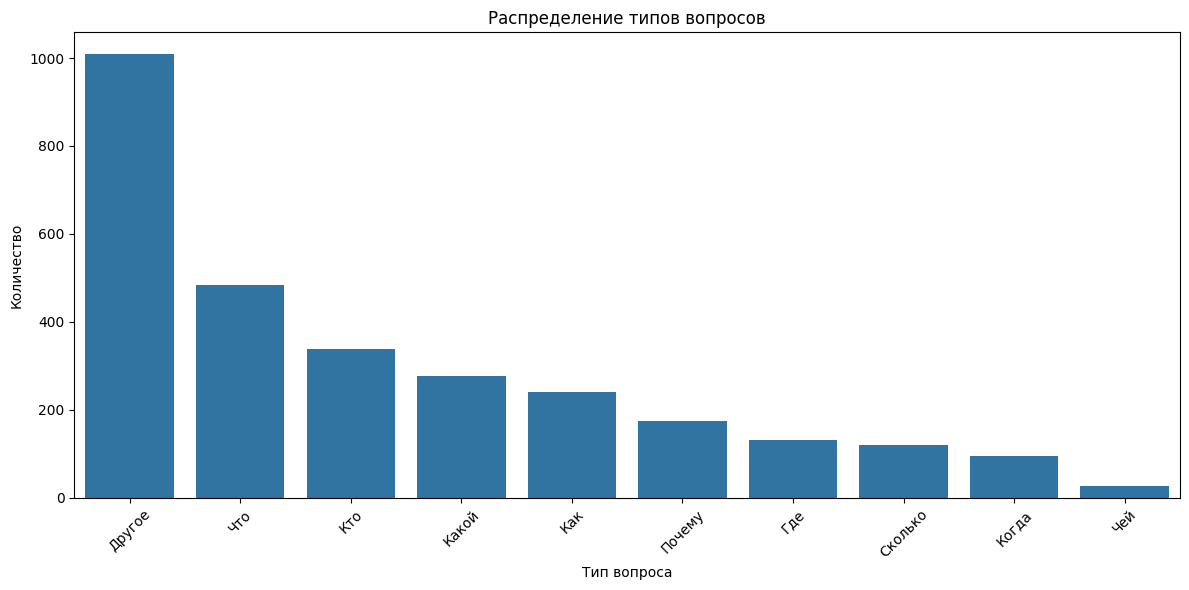

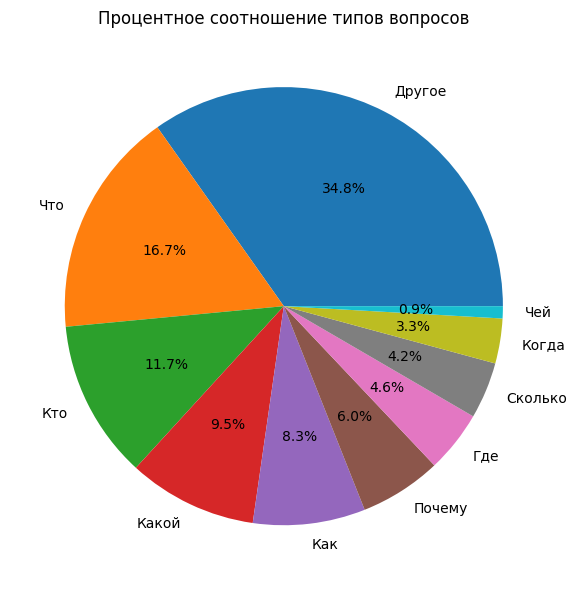

(      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
2892         498         2892   
2893         499         2893   
2894         499         2894   
2895         499         2895   
2896         499         2896   

                                          question_text  question_word_count  \
0                                     Где бегала шпана?                    3   
1                           Почему Люда ударила Артема?                    4   
2                      Как развлекались в парке ребята?                    5   
3     Что происходило, когда Людочка бралась подстри...                    7   
4          Какие волосы росли на голове у Артемки-мыла?                    7   
...                                                 ...                  ...   
2892  Как назван корабль, спущенный на вод

In [103]:
print(q_types_analizator(questions_train))

#### Val

Распределение типов вопросов:
Другое: 177 (33.46%)
Что: 80 (15.12%)
Какой: 63 (11.91%)
Кто: 60 (11.34%)
Как: 51 (9.64%)
Почему: 39 (7.37%)
Где: 31 (5.86%)
Сколько: 17 (3.21%)
Когда: 11 (2.08%)


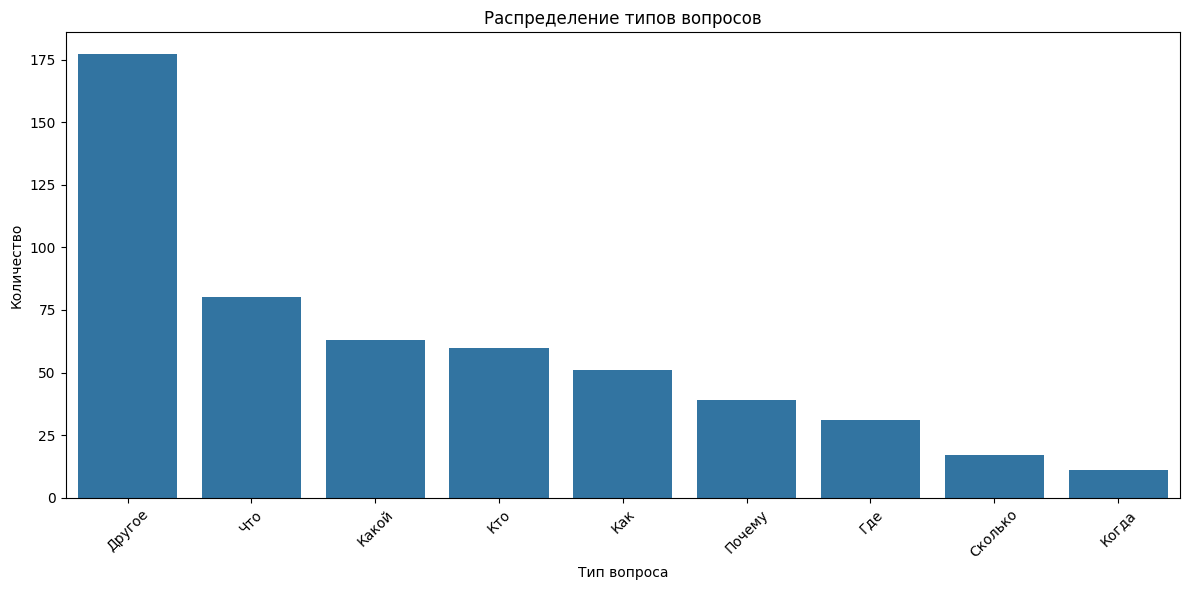

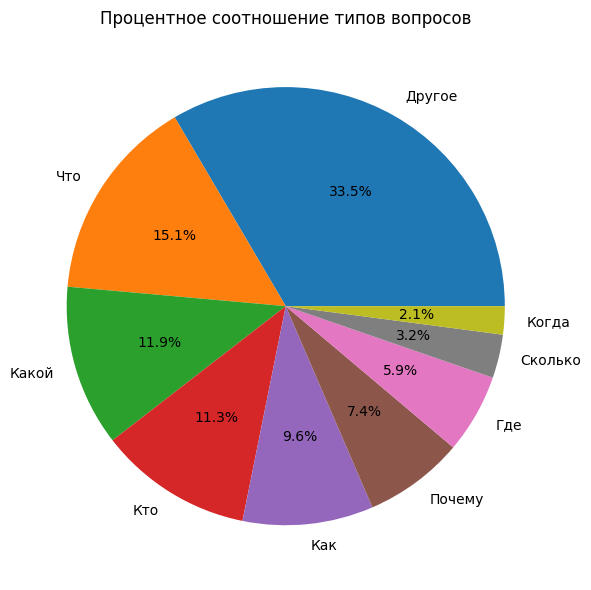

(     passage_id  question_id  \
0             0            0   
1             0            1   
2             1            2   
3             1            3   
4             2            4   
..          ...          ...   
524          99          524   
525          99          525   
526          99          526   
527          99          527   
528          99          528   

                                         question_text  question_word_count  \
0           Почему Солженицына перевозили спецконвоем?                    4   
1    Как люди попадали в тюрьмы особого типа на Сол...                    9   
2                   Кто в ноябре подал иск в арбитраж?                    7   
3    Когда было зарегистрировано обращения Сбербанк...                    8   
4                                  Кто начал слепнуть?                    3   
..                                                 ...                  ...   
524  Где был задержан Лукка Рокко Маньотта в связи ...       

In [104]:
print(q_types_analizator(questions_val))

#### Test

Распределение типов вопросов:
Другое: 579 (31.94%)
Что: 373 (20.57%)
Кто: 245 (13.51%)
Какой: 183 (10.09%)
Как: 140 (7.72%)
Почему: 93 (5.13%)
Где: 82 (4.52%)
Когда: 56 (3.09%)
Сколько: 51 (2.81%)
Чей: 11 (0.61%)


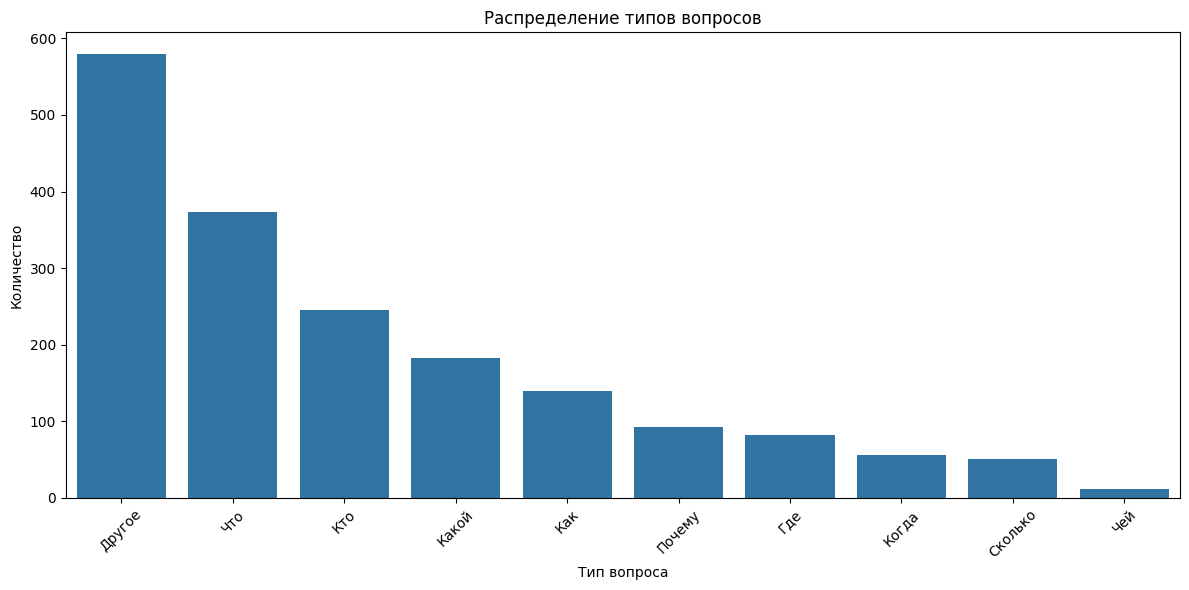

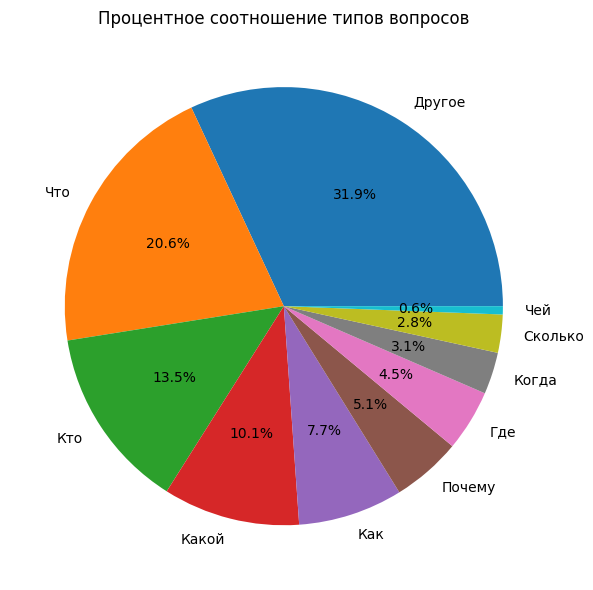

(      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
1808         320         1808   
1809         320         1809   
1810         320         1810   
1811         321         1811   
1812         321         1812   

                                          question_text  question_word_count  \
0                             О чем дневник Анны Франк?                    5   
1                Каким будет приложение Anne Frank App?                    6   
2     Какая информация войдет в новой мобильное прил...                    7   
3      Где скрывались члены семьи Франк и другие евреи?                    8   
4     Как Анна называла место, где она и ее семья ск...                   12   
...                                                 ...                  ...   
1808              Почему медвежонок решил 

In [105]:
print(q_types_analizator(questions_test))

### Анализ частоты слов в вопросах

In [106]:
def q_keywords_analizator(df, top_n=50):
    """
    Анализирует наиболее часто встречающиеся слова в вопросах.
    """

    df['cleaned_question'] = df['question_text'].apply(clean_text)

    all_words = []
    for text in df['cleaned_question']:
        words = text.split()
        all_words.extend(words)

    filtered_words = [word for word in all_words if word not in russian_stopwords and len(word) > 2]

    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(top_n)

    print(f"\nТоп-{top_n} наиболее часто встречающихся слов в вопросах:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")

    plt.figure(figsize=(12, 8))
    words, freqs = zip(*most_common_words)
    plt.barh(words, freqs, color='skyblue')
    plt.title(f'Топ-{top_n} наиболее часто встречающихся слов в вопросах')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.tight_layout()
    plt.show()

    return df, most_common_words

#### Train


Топ-50 наиболее часто встречающихся слов в вопросах:
какой: 146
сколько: 133
какие: 126
кого: 91
после: 81
кем: 67
каком: 65
чего: 61
году: 61
каких: 53
какую: 48
какого: 47
какое: 45
какая: 44
года: 42
каким: 41
куда: 41
зовут: 40
кому: 37
время: 35
является: 33
чём: 33
звали: 32
автор: 31
произошло: 31
человек: 30
лет: 27
изза: 26
какова: 25
роль: 25
себя: 25
сделал: 25
матче: 24
чему: 24
того: 24
мнению: 23
своей: 22
мира: 22
стал: 22
случилось: 22
сделать: 21
сборной: 21
мальчик: 20
сообщил: 19
свою: 19
человека: 19
людей: 18
сообщает: 18
жизни: 17
зачем: 17


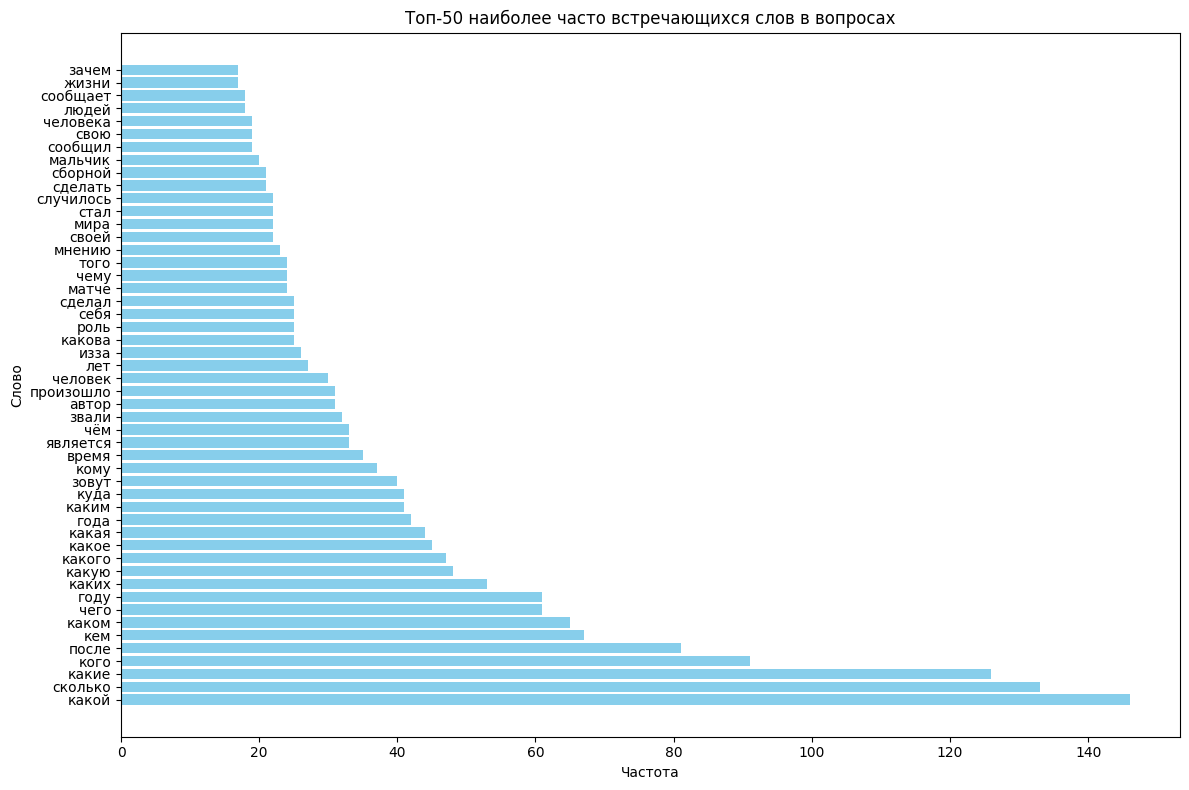

(      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
2892         498         2892   
2893         499         2893   
2894         499         2894   
2895         499         2895   
2896         499         2896   

                                          question_text  question_word_count  \
0                                     Где бегала шпана?                    3   
1                           Почему Люда ударила Артема?                    4   
2                      Как развлекались в парке ребята?                    5   
3     Что происходило, когда Людочка бралась подстри...                    7   
4          Какие волосы росли на голове у Артемки-мыла?                    7   
...                                                 ...                  ...   
2892  Как назван корабль, спущенный на вод

In [107]:
print(q_keywords_analizator(questions_train))

#### Val


Топ-50 наиболее часто встречающихся слов в вопросах:
какой: 32
какие: 24
кого: 21
сколько: 18
кем: 17
каких: 14
какое: 14
чего: 13
после: 12
звали: 10
году: 10
какая: 9
кому: 9
какую: 9
получил: 9
лет: 8
является: 8
автор: 8
зовут: 8
суд: 7
каком: 7
себя: 7
куда: 7
убитого: 7
фильм: 7
рокко: 7
иск: 6
произошло: 6
каким: 6
twitter: 6
сообщает: 6
какого: 6
правительства: 6
сделал: 6
хейзел: 6
тренер: 6
джейд: 6
маньотта: 6
работал: 5
чём: 5
речь: 5
книга: 5
конкурсе: 5
года: 5
место: 5
женщина: 5
случилось: 5
2007: 5
изза: 5
заявил: 5


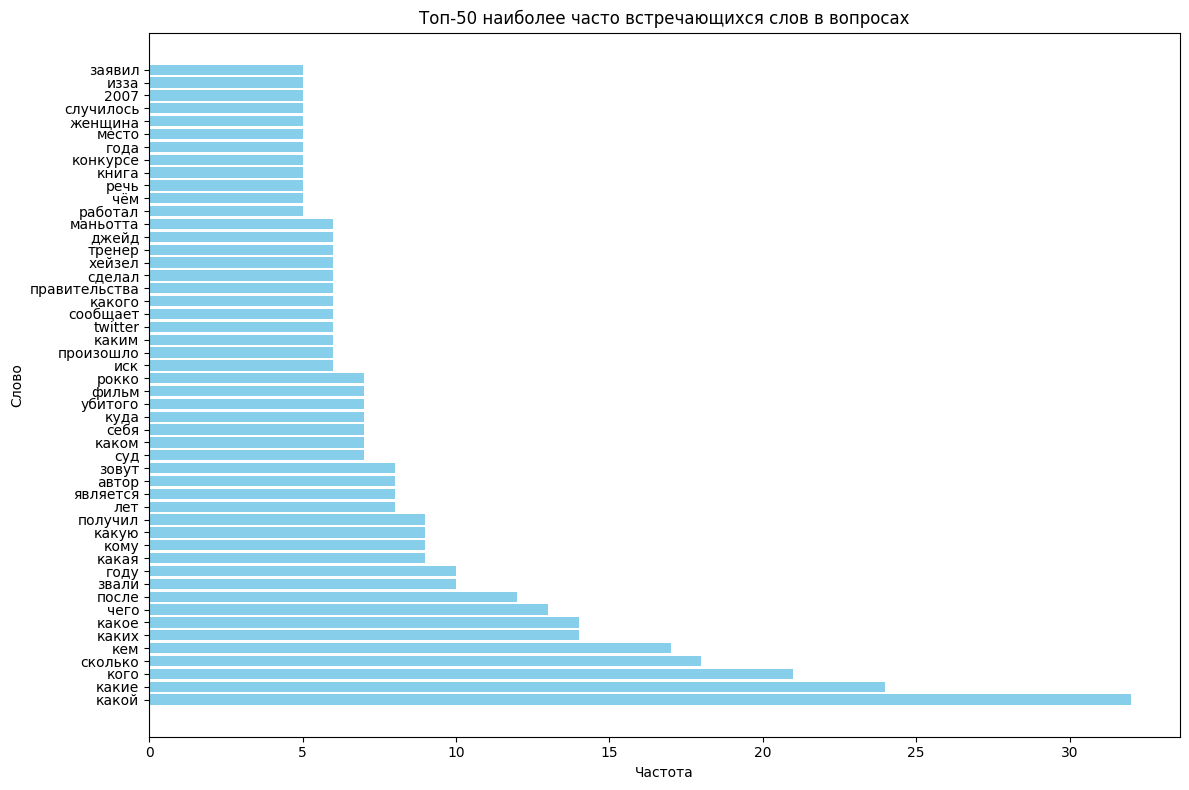

(     passage_id  question_id  \
0             0            0   
1             0            1   
2             1            2   
3             1            3   
4             2            4   
..          ...          ...   
524          99          524   
525          99          525   
526          99          526   
527          99          527   
528          99          528   

                                         question_text  question_word_count  \
0           Почему Солженицына перевозили спецконвоем?                    4   
1    Как люди попадали в тюрьмы особого типа на Сол...                    9   
2                   Кто в ноябре подал иск в арбитраж?                    7   
3    Когда было зарегистрировано обращения Сбербанк...                    8   
4                                  Кто начал слепнуть?                    3   
..                                                 ...                  ...   
524  Где был задержан Лукка Рокко Маньотта в связи ...       

In [108]:
print(q_keywords_analizator(questions_val))

#### Test


Топ-50 наиболее часто встречающихся слов в вопросах:
какой: 105
какие: 65
кого: 64
сколько: 57
кем: 51
каком: 48
после: 44
чего: 37
какое: 36
чём: 34
какого: 34
каким: 33
году: 31
каких: 29
какая: 26
случилось: 25
сделал: 25
автор: 24
какую: 24
кому: 24
куда: 24
года: 23
человек: 22
зовут: 21
произошло: 21
время: 20
россии: 19
мнению: 18
является: 18
бержере: 18
герой: 16
перед: 15
матче: 15
которого: 14
свою: 14
стал: 13
умер: 13
мира: 13
себя: 13
словам: 12
том: 12
сообщил: 12
городе: 11
автора: 11
жизни: 11
сказал: 11
новости: 11
увидел: 11
сделали: 11
любовь: 11


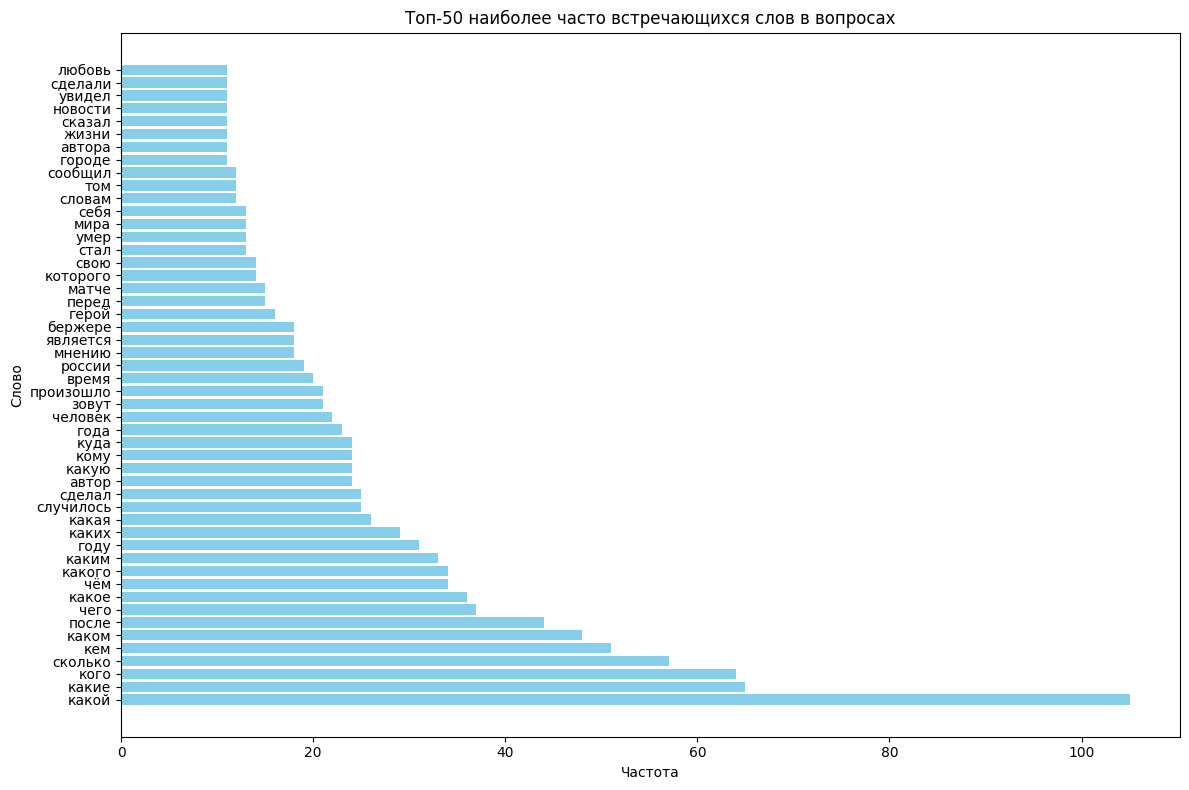

(      passage_id  question_id  \
0              0            0   
1              0            1   
2              0            2   
3              0            3   
4              0            4   
...          ...          ...   
1808         320         1808   
1809         320         1809   
1810         320         1810   
1811         321         1811   
1812         321         1812   

                                          question_text  question_word_count  \
0                             О чем дневник Анны Франк?                    5   
1                Каким будет приложение Anne Frank App?                    6   
2     Какая информация войдет в новой мобильное прил...                    7   
3      Где скрывались члены семьи Франк и другие евреи?                    8   
4     Как Анна называла место, где она и ее семья ск...                   12   
...                                                 ...                  ...   
1808              Почему медвежонок решил 

In [109]:
print(q_keywords_analizator(questions_test))

### Анализ сложности вопросов

In [110]:
def q_comlex_analizator(df):
    """
    Анализирует сложность вопросов
    """
    df['punctuation_count'] = df['question_text'].apply(
        lambda x: sum(1 for char in x if char in string.punctuation)
    )

    df['comma_count'] = df['question_text'].apply(
        lambda x: x.count(',')
    )

    df['punctuation_ratio'] = df['punctuation_count'] / df['question_char_count']

    plt.figure(figsize=(10, 6))
    sns.histplot(df['punctuation_count'], kde=True)
    plt.title('Распределение количества знаков препинания в вопросах')
    plt.xlabel('Количество знаков препинания')
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(df['question_word_count'], df['punctuation_count'], alpha=0.5)
    plt.title('Зависимость количества знаков препинания от длины вопроса')
    plt.xlabel('Количество слов')
    plt.ylabel('Количество знаков препинания')
    plt.show()

    return df

## Анализ ответов

### Анализ длины ответов

In [111]:
def len_ans_analayzer(df):
    """
    Анализирует распределение длины ответов.
    """
    df['answer_word_count'] = df['answer_text'].apply(lambda x: len(str(x).split()))

    df['answer_char_count'] = df['answer_text'].apply(lambda x: len(str(x)))

    print("Статистика длины ответов:")
    print(f"Медианное количество слов: {df['answer_word_count'].median()}")
    print(f"Минимальное количество слов: {df['answer_word_count'].min()}")
    print(f"Максимальное количество слов: {df['answer_word_count'].max()}")

    print(f"Медианное количество символов: {df['answer_char_count'].median()}")
    print(f"Минимальное количество символов: {df['answer_char_count'].min()}")
    print(f"Максимальное количество символов: {df['answer_char_count'].max()}")

    plt.figure(figsize=(10, 6))
    sns.histplot(df['answer_word_count'], kde=True)
    plt.title('Распределение количества слов в ответах')
    plt.xlabel('Количество слов')
    plt.ylabel('Частота')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df['answer_char_count'], kde=True)
    plt.title('Распределение количества символов в ответах')
    plt.xlabel('Количество символов')
    plt.ylabel('Частота')
    plt.show()

    return df

#### Train

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 133
Медианное количество символов: 24.0
Минимальное количество символов: 1
Максимальное количество символов: 734


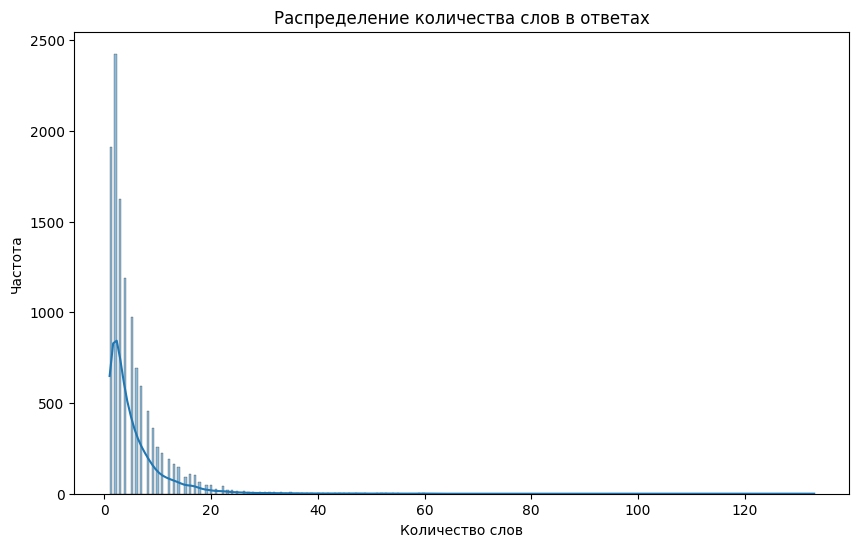

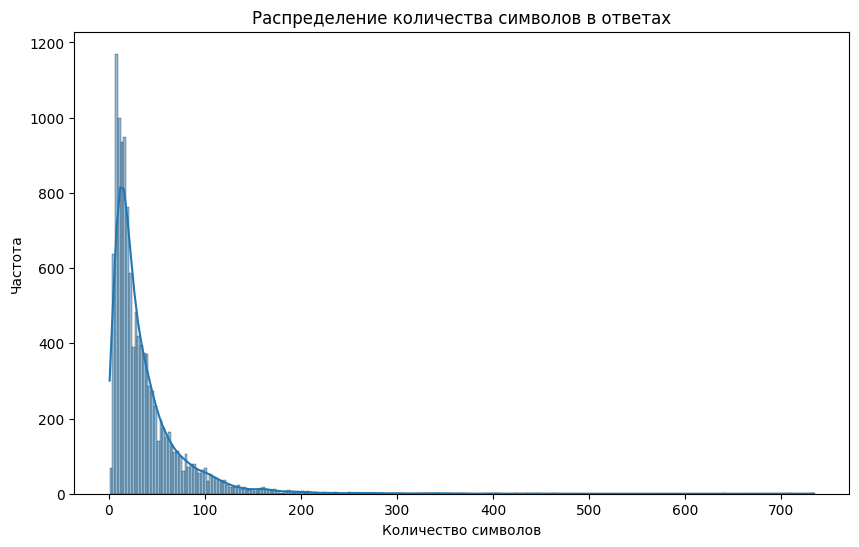

       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   
4                                        Он ее оскорбил.      0   
...                                                  ... 

In [112]:
print(len_ans_analayzer(answers_train))

#### Val

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 59
Медианное количество символов: 26.0
Минимальное количество символов: 3
Максимальное количество символов: 451


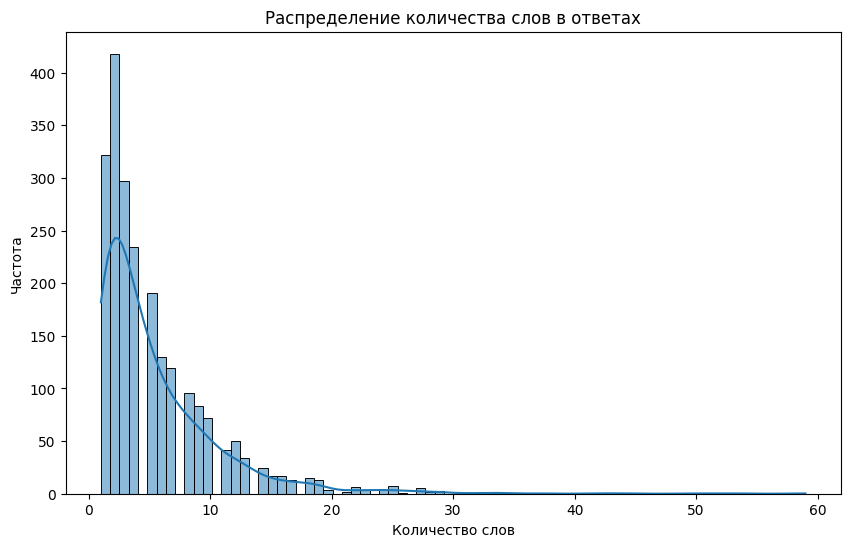

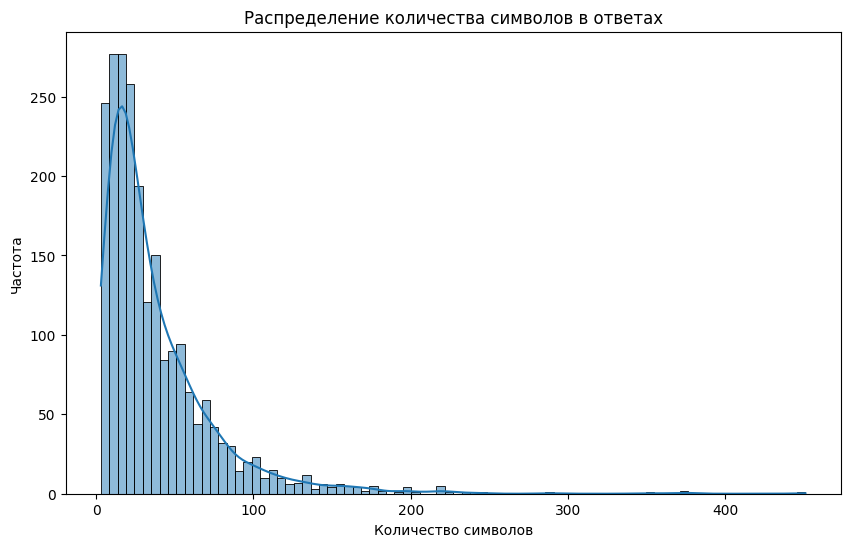

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, что он был особо важным заключённым и ...      1   
...                                                 ...    ...   
2230     

In [113]:
print(len_ans_analayzer(answers_val))

#### Test

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 77
Медианное количество символов: 24.0
Минимальное количество символов: 2
Максимальное количество символов: 555


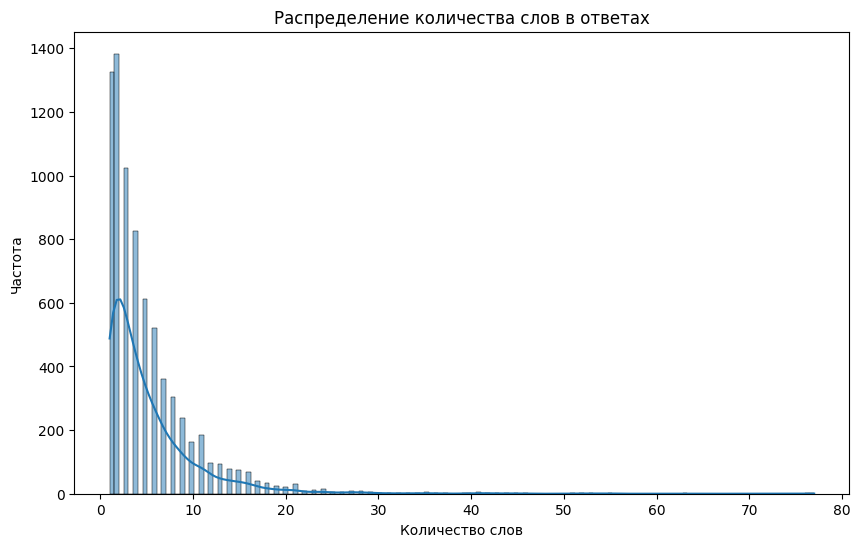

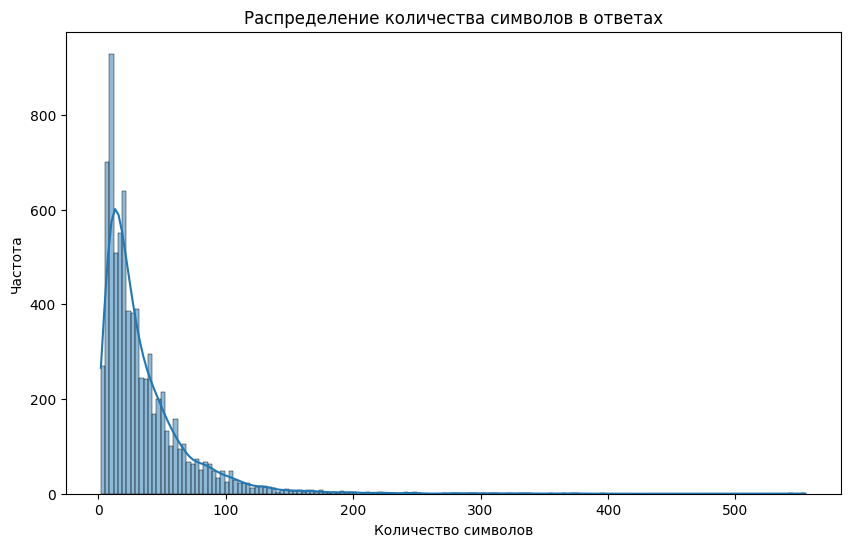

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            1          4   
...          ...          ...        ...   
7609         321         1811       7609   
7610         321         1812       7610   
7611         321         1812       7611   
7612         321         1812       7612   
7613         321         1812       7613   

                                            answer_text  answer_word_count  \
0                             Дневник об отметках Анны.                  4   
1                Дневник о школьных годах девочки Анны.                  6   
2     О жизни еврейской девочки во время гонения евр...                  9   
3     Анна описывала свою жизнь и жизнь близких, ког...                 11   
4                             Приложение будет платным.                  3   
...

In [114]:
print(len_ans_analayzer(answers_test))

### Анализ правильных и неправильных ответов

In [115]:
def ans_corr_analayzer(df):
    """
    Анализирует распределение правильных и неправильных ответов.
    """

    label_counts = df['label'].value_counts()
    label_percentages = (label_counts / len(df) * 100).round(2)

    print("\nРаспределение правильных и неправильных ответов:")
    for label, count in label_counts.items():
        percentage = label_percentages[label]
        label_name = "Правильный" if label == 0 else "Неправильный"
        print(f"{label_name} (label={label}): {count} ({percentage}%)")

    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Распределение правильных и неправильных ответов')
    plt.xlabel('Метка (0 - правильный, 1 - неправильный)')
    plt.ylabel('Количество')
    plt.xticks([0, 1], ['Правильный (0)', 'Неправильный (1)'])
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.pie(label_counts, labels=['Правильный (0)', 'Неправильный (1)'], autopct='%1.1f%%')
    plt.title('Процентное соотношение правильных и неправильных ответов')
    plt.show()

    return df

#### Train

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 133
Медианное количество символов: 24.0
Минимальное количество символов: 1
Максимальное количество символов: 734


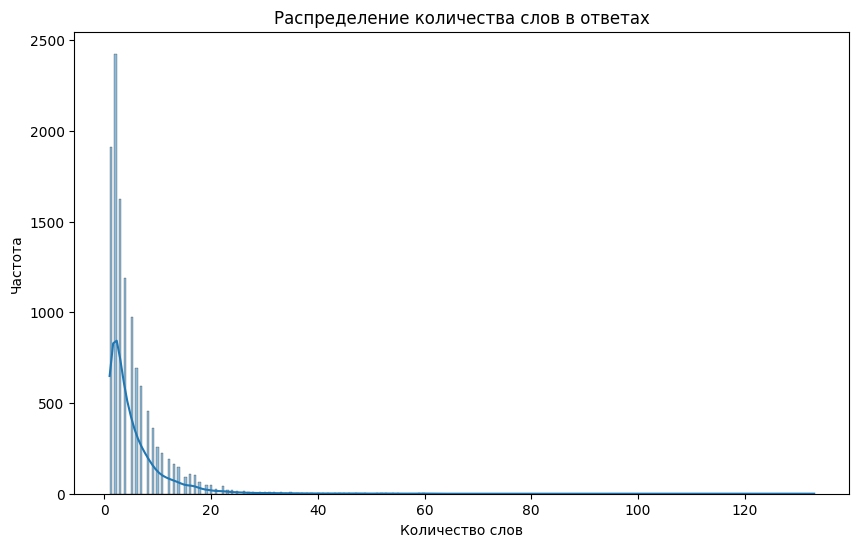

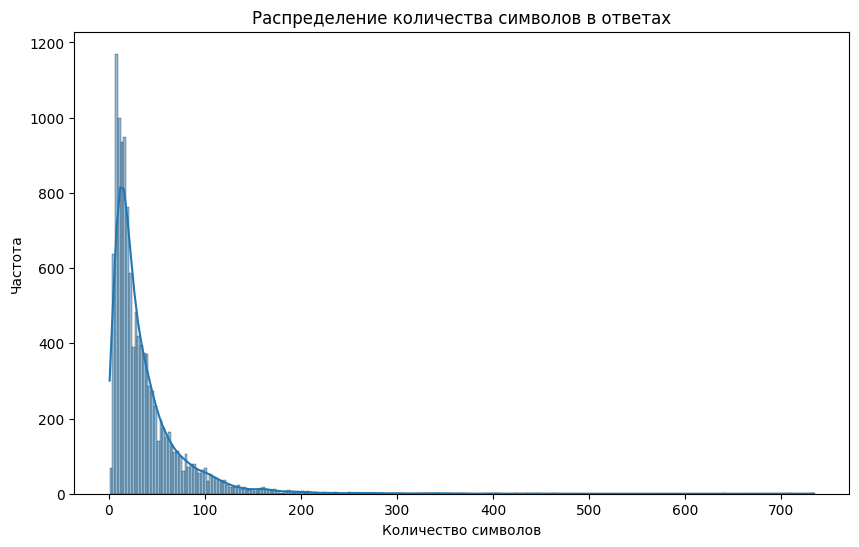

       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   
4                                        Он ее оскорбил.      0   
...                                                  ... 

In [116]:
print(len_ans_analayzer(answers_train))

#### Val

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 59
Медианное количество символов: 26.0
Минимальное количество символов: 3
Максимальное количество символов: 451


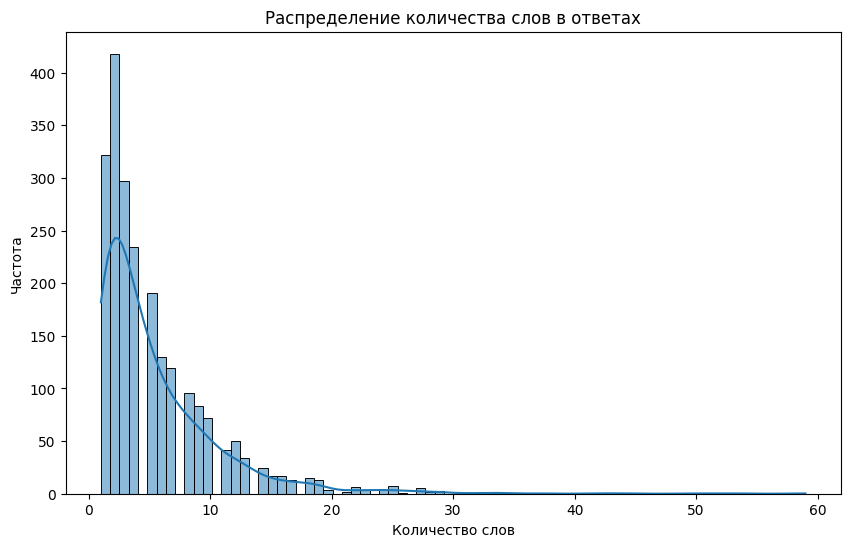

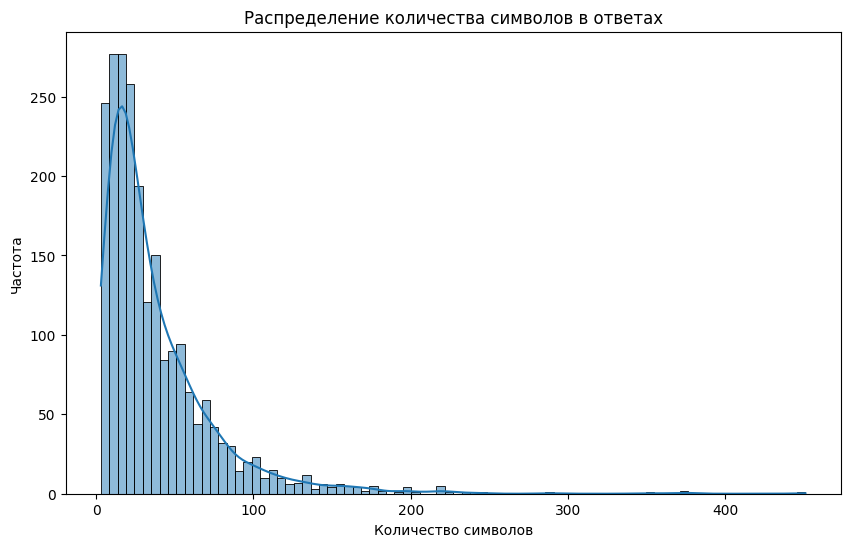

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, что он был особо важным заключённым и ...      1   
...                                                 ...    ...   
2230     

In [117]:
print(len_ans_analayzer(answers_val))

#### Test

Статистика длины ответов:
Медианное количество слов: 4.0
Минимальное количество слов: 1
Максимальное количество слов: 77
Медианное количество символов: 24.0
Минимальное количество символов: 2
Максимальное количество символов: 555


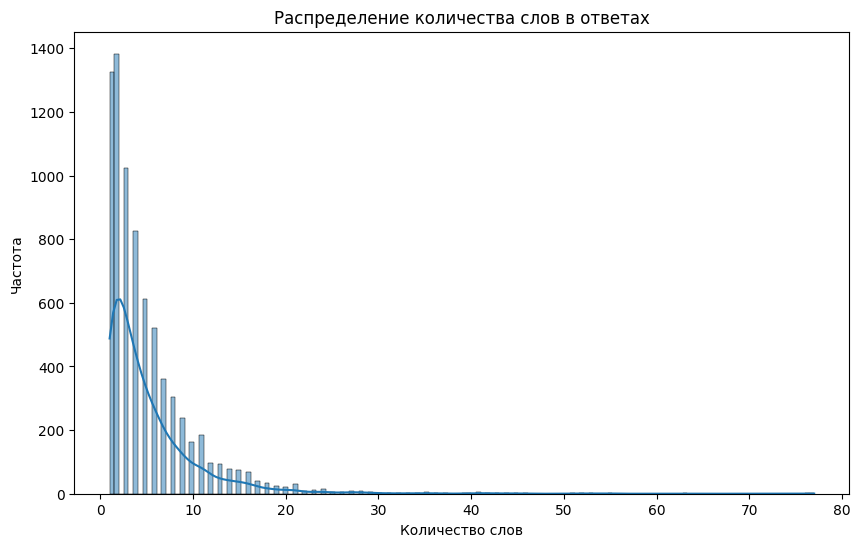

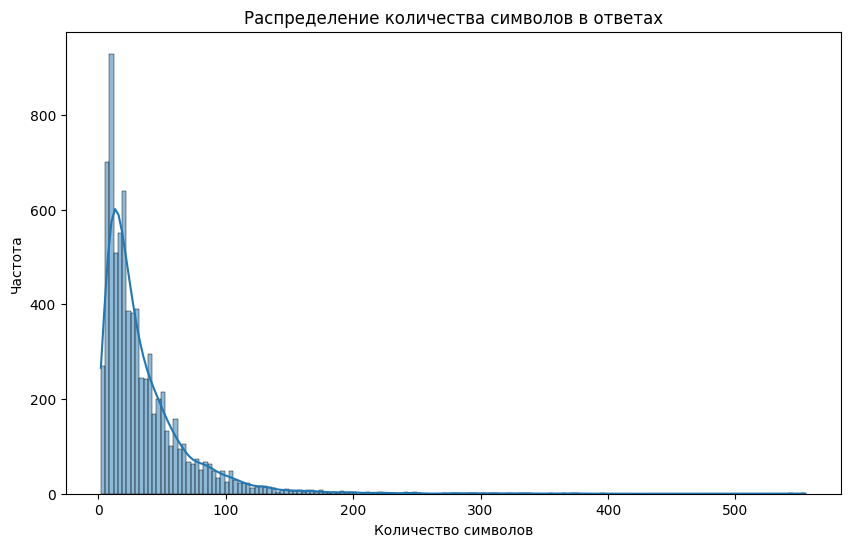

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            1          4   
...          ...          ...        ...   
7609         321         1811       7609   
7610         321         1812       7610   
7611         321         1812       7611   
7612         321         1812       7612   
7613         321         1812       7613   

                                            answer_text  answer_word_count  \
0                             Дневник об отметках Анны.                  4   
1                Дневник о школьных годах девочки Анны.                  6   
2     О жизни еврейской девочки во время гонения евр...                  9   
3     Анна описывала свою жизнь и жизнь близких, ког...                 11   
4                             Приложение будет платным.                  3   
...

In [118]:
print(len_ans_analayzer(answers_test))

### Анализ частоты слов в ответах

In [119]:
def ans_keywords_analayzer(df, top_n=20):
    """
    Анализирует наиболее часто встречающиеся слова в ответах.
    """

    df['cleaned_answer'] = df['answer_text'].apply(clean_text)

    all_words = []
    for text in df['cleaned_answer']:
        words = text.split()
        all_words.extend(words)

    filtered_words = [word for word in all_words if word not in russian_stopwords and len(word) > 2]

    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(top_n)

    print(f"\nТоп-{top_n} наиболее часто встречающихся слов в ответах:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")

    plt.figure(figsize=(12, 8))
    words, freqs = zip(*most_common_words)
    plt.barh(words, freqs, color='lightgreen')
    plt.title(f'Топ-{top_n} наиболее часто встречающихся слов в ответах')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.tight_layout()
    plt.show()

    return df, most_common_words

#### Train


Топ-20 наиболее часто встречающихся слов в ответах:
это: 167
года: 161
году: 150
человек: 146
потому: 142
нет: 112
изза: 110
после: 105
том: 101
россии: 92
ему: 89
него: 82
того: 68
лет: 68
все: 67
своей: 65
один: 63
хочет: 57
жизни: 57
себя: 55


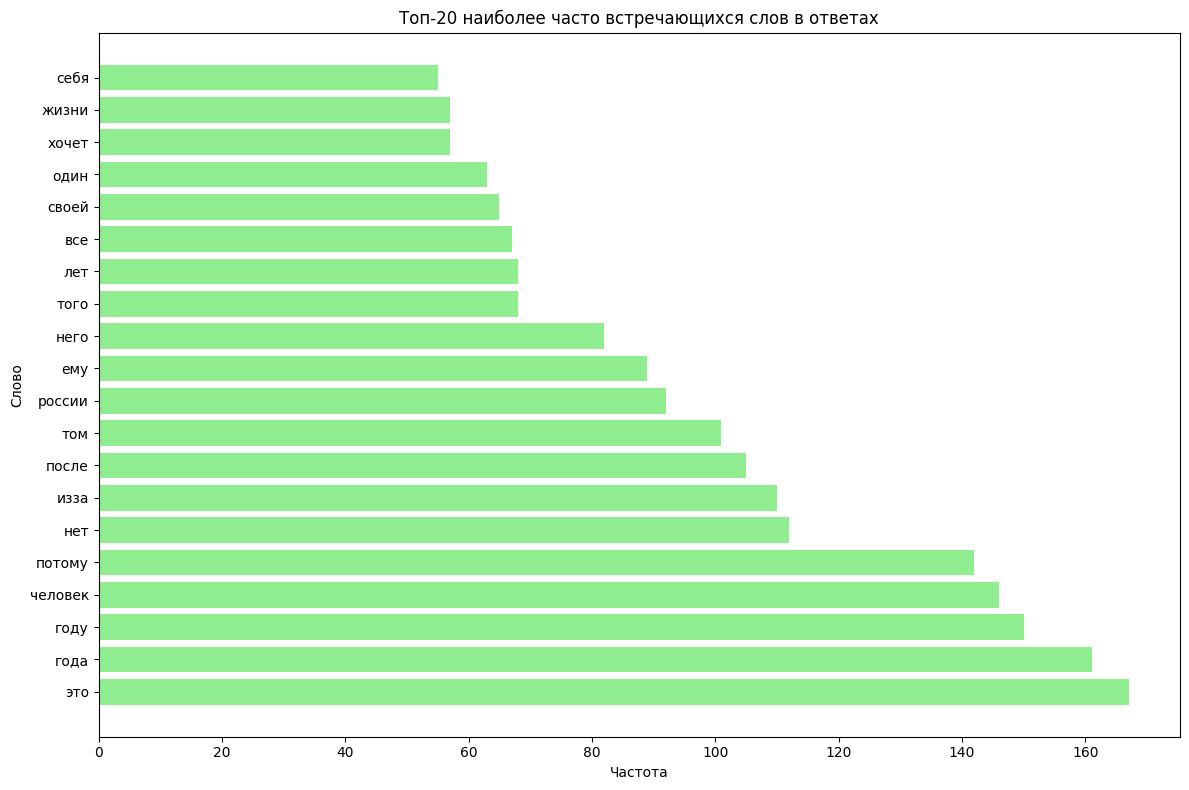

(       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   
4                                        Он ее оскорбил.      0   
...                                                  ...

In [120]:
print(ans_keywords_analayzer(answers_train))

#### Val


Топ-20 наиболее часто встречающихся слов в ответах:
потому: 49
это: 34
года: 28
ему: 27
нет: 26
себя: 23
после: 23
все: 22
изза: 21
том: 20
мать: 19
человек: 17
лет: 17
news: 17
него: 16
году: 15
книги: 15
люди: 14
винтовки: 14
россии: 13


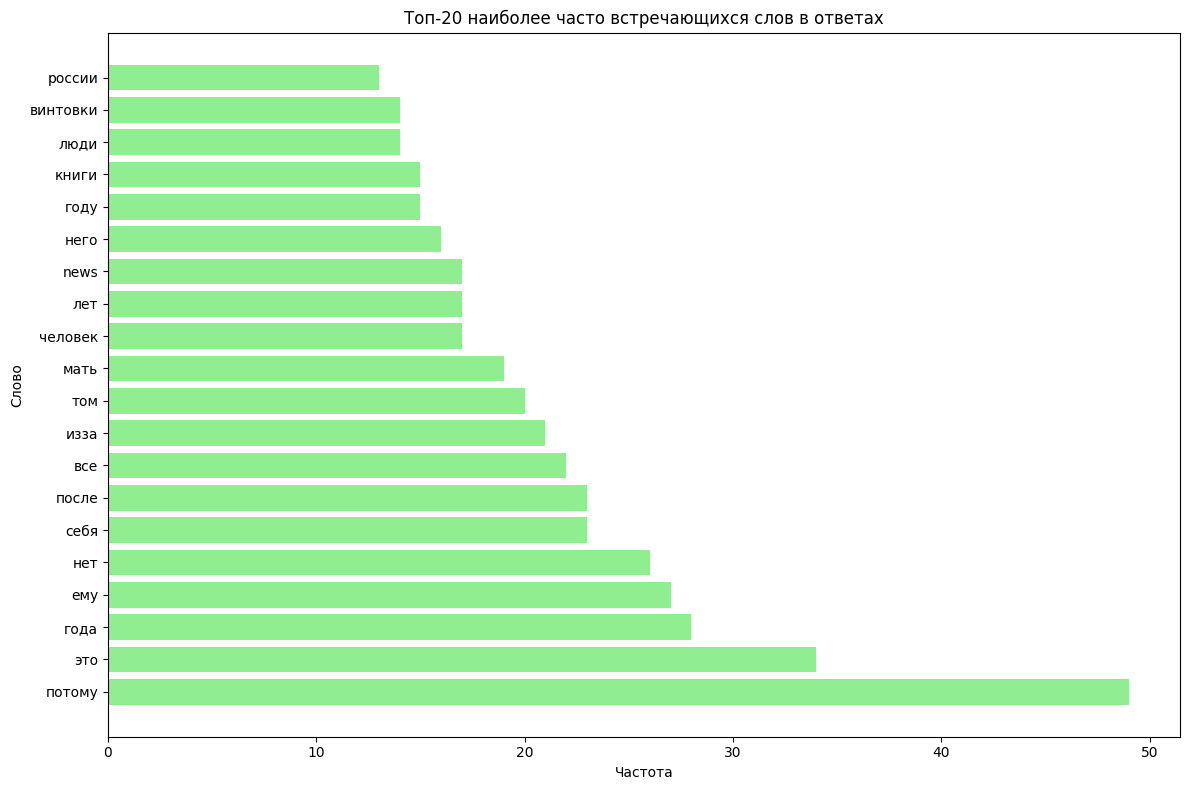

(      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, что он был особо важным заключённым и ...      1   
...                                                 ...    ...   
2230    

In [121]:
print(ans_keywords_analayzer(answers_val))

#### Test


Топ-20 наиболее часто встречающихся слов в ответах:
это: 131
года: 91
человек: 74
году: 72
том: 69
ему: 66
после: 65
потому: 60
изза: 54
все: 52
время: 50
россии: 42
того: 41
нет: 39
него: 37
любовь: 35
уже: 34
человека: 32
себя: 31
своей: 31


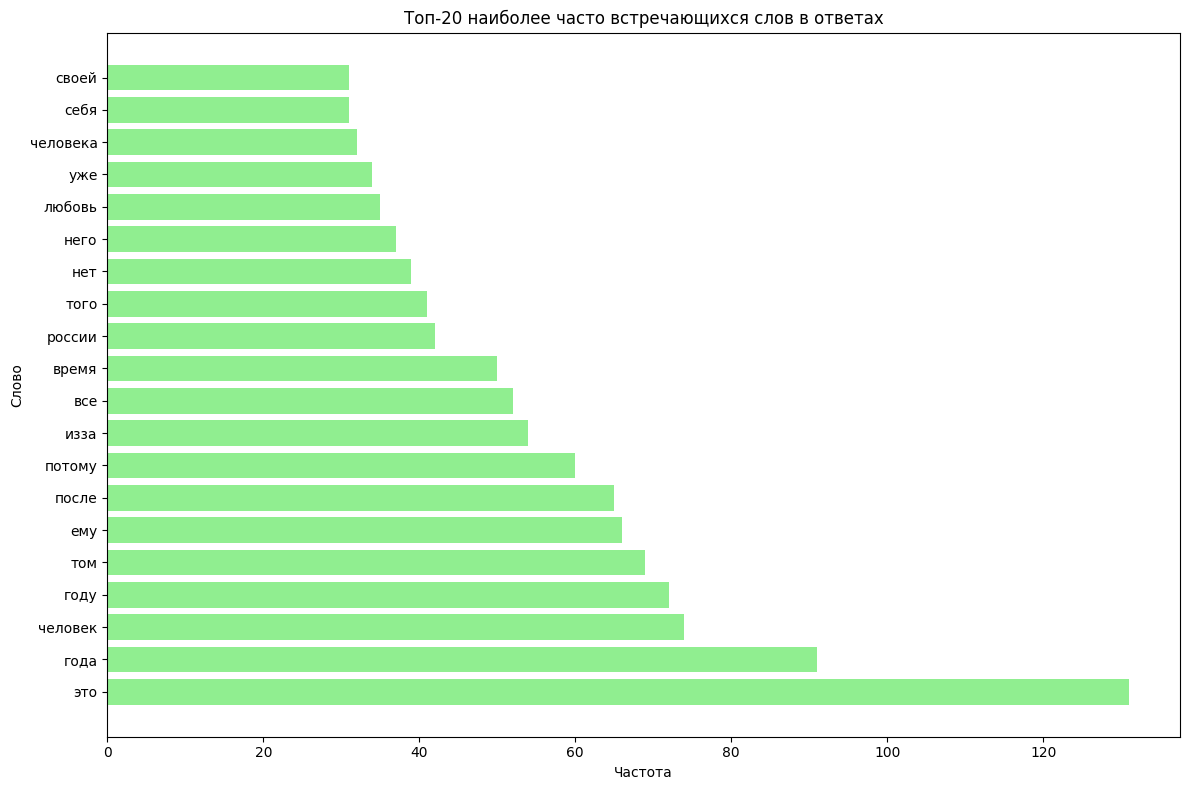

(      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            1          4   
...          ...          ...        ...   
7609         321         1811       7609   
7610         321         1812       7610   
7611         321         1812       7611   
7612         321         1812       7612   
7613         321         1812       7613   

                                            answer_text  answer_word_count  \
0                             Дневник об отметках Анны.                  4   
1                Дневник о школьных годах девочки Анны.                  6   
2     О жизни еврейской девочки во время гонения евр...                  9   
3     Анна описывала свою жизнь и жизнь близких, ког...                 11   
4                             Приложение будет платным.                  3   
..

In [122]:
print(ans_keywords_analayzer(answers_test))

### Анализ структуры ответов

In [123]:
def ans_stuct_analayzer(df):
    """
    Анализирует структуру ответов (типы предложений, наличие ключевых слов).
    """
    df['has_period'] = df['answer_text'].apply(lambda x: '.' in str(x))
    df['has_question_mark'] = df['answer_text'].apply(lambda x: '?' in str(x))
    df['has_exclamation_mark'] = df['answer_text'].apply(lambda x: '!' in str(x))
    df['has_comma'] = df['answer_text'].apply(lambda x: ',' in str(x))

    print("\nСтруктурные характеристики ответов:")
    print(f"Содержат точку: {df['has_period'].sum()} ({df['has_period'].mean()*100:.2f}%)")
    print(f"Содержат вопросительный знак: {df['has_question_mark'].sum()} ({df['has_question_mark'].mean()*100:.2f}%)")
    print(f"Содержат восклицательный знак: {df['has_exclamation_mark'].sum()} ({df['has_exclamation_mark'].mean()*100:.2f}%)")
    print(f"Содержат запятую: {df['has_comma'].sum()} ({df['has_comma'].mean()*100:.2f}%)")

    def get_first_word(text):
        text = str(text).strip().lower()
        if text:
            words = text.split()
            if words:
                return words[0]
        return ""

    df['first_word'] = df['answer_text'].apply(get_first_word)
    first_word_counts = df['first_word'].value_counts().head(10)

    print("\nТоп-10 первых слов в ответах:")
    for word, count in first_word_counts.items():
        percentage = count / len(df) * 100
        print(f"{word}: {count} ({percentage:.2f}%)")

    plt.figure(figsize=(12, 6))
    sns.barplot(x=first_word_counts.index, y=first_word_counts.values)
    plt.title('Топ-10 первых слов в ответах')
    plt.xlabel('Слово')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

#### Train


Структурные характеристики ответов:
Содержат точку: 11950 (100.00%)
Содержат вопросительный знак: 28 (0.23%)
Содержат восклицательный знак: 29 (0.24%)
Содержат запятую: 2314 (19.36%)

Топ-10 первых слов в ответах:
в: 755 (6.32%)
на: 284 (2.38%)
он: 282 (2.36%)
о: 145 (1.21%)
за: 141 (1.18%)
с: 132 (1.10%)
потому: 115 (0.96%)
у: 93 (0.78%)
не: 80 (0.67%)
она: 78 (0.65%)


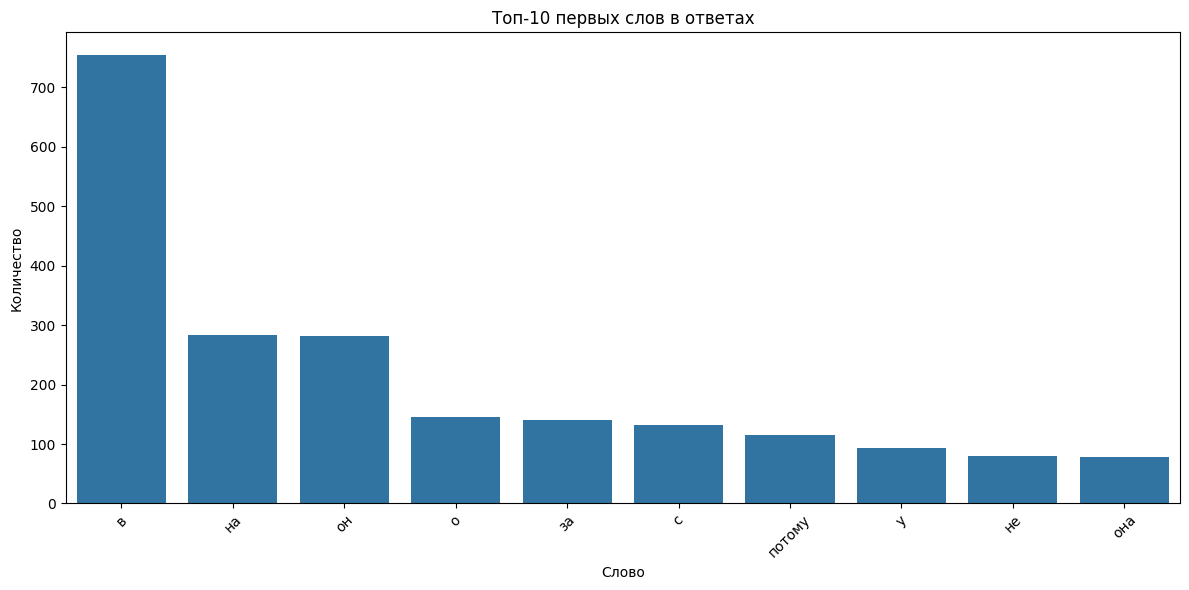

       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   
4                                        Он ее оскорбил.      0   
...                                                  ... 

In [124]:
print(ans_stuct_analayzer(answers_train))

#### Val


Структурные характеристики ответов:
Содержат точку: 2235 (100.00%)
Содержат вопросительный знак: 2 (0.09%)
Содержат восклицательный знак: 6 (0.27%)
Содержат запятую: 420 (18.79%)

Топ-10 первых слов в ответах:
в: 115 (5.15%)
он: 55 (2.46%)
на: 46 (2.06%)
потому: 41 (1.83%)
за: 36 (1.61%)
его: 23 (1.03%)
у: 23 (1.03%)
о: 22 (0.98%)
с: 21 (0.94%)
они: 16 (0.72%)


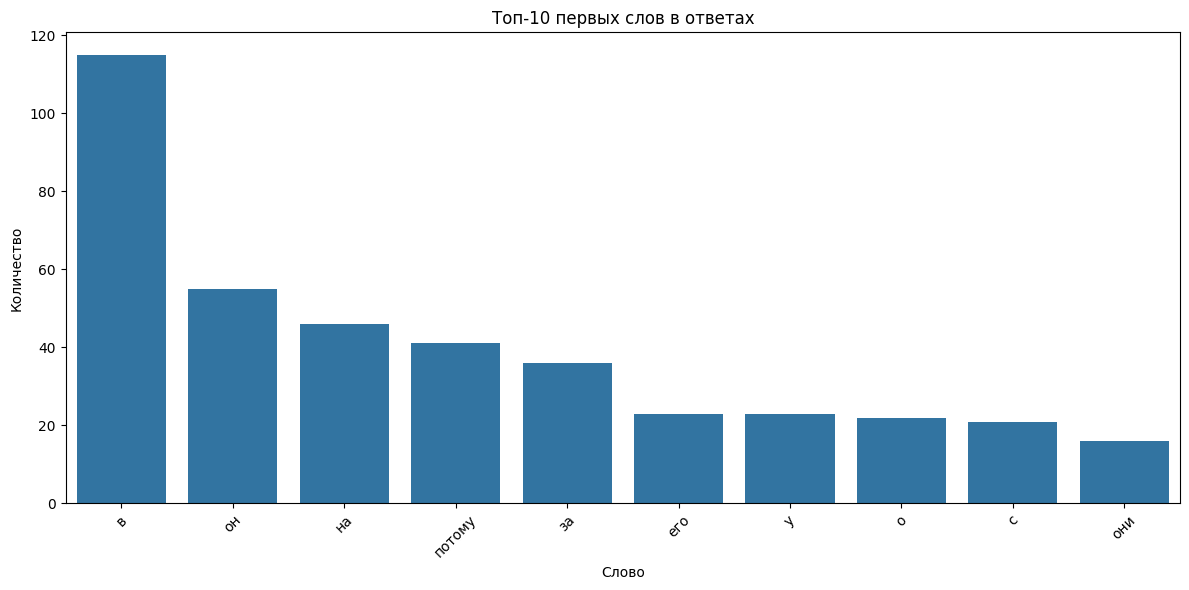

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, что он был особо важным заключённым и ...      1   
...                                                 ...    ...   
2230     

In [125]:
print(ans_stuct_analayzer(answers_val))

#### Test


Структурные характеристики ответов:
Содержат точку: 7614 (100.00%)
Содержат вопросительный знак: 8 (0.11%)
Содержат восклицательный знак: 15 (0.20%)
Содержат запятую: 1321 (17.35%)

Топ-10 первых слов в ответах:
в: 449 (5.90%)
он: 201 (2.64%)
на: 137 (1.80%)
она: 96 (1.26%)
о: 93 (1.22%)
они: 74 (0.97%)
у: 73 (0.96%)
с: 69 (0.91%)
за: 61 (0.80%)
его: 58 (0.76%)


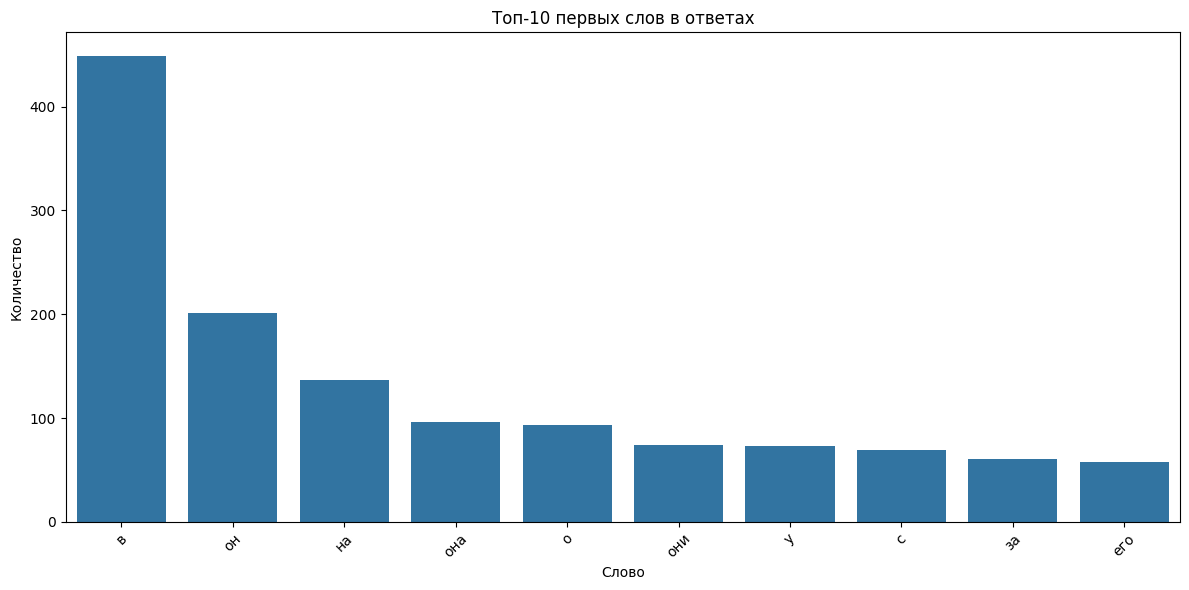

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            1          4   
...          ...          ...        ...   
7609         321         1811       7609   
7610         321         1812       7610   
7611         321         1812       7611   
7612         321         1812       7612   
7613         321         1812       7613   

                                            answer_text  answer_word_count  \
0                             Дневник об отметках Анны.                  4   
1                Дневник о школьных годах девочки Анны.                  6   
2     О жизни еврейской девочки во время гонения евр...                  9   
3     Анна описывала свою жизнь и жизнь близких, ког...                 11   
4                             Приложение будет платным.                  3   
...

In [126]:
print(ans_stuct_analayzer(answers_test))

### Анализ зависимости длины ответа от его правильности

In [127]:
def len_corr_diff_analayzer(df):
    """
    Анализирует зависимость длины ответа от его правильности.
    """

    grouped = df.groupby('label')['answer_word_count'].agg(['mean', 'median', 'min', 'max'])

    print("\nДлина ответов в зависимости от правильности:")
    for label, stats in grouped.iterrows():
        label_name = "Правильные ответы" if label == 0 else "Неправильные ответы"
        print(f"\n{label_name} (label={label}):")
        print(f"Среднее количество слов: {stats['mean']:.2f}")
        print(f"Медианное количество слов: {stats['median']}")
        print(f"Минимальное количество слов: {stats['min']}")
        print(f"Максимальное количество слов: {stats['max']}")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='answer_word_count', data=df)
    plt.title('Распределение длины ответов в зависимости от правильности')
    plt.xlabel('Метка (0 - правильный, 1 - неправильный)')
    plt.ylabel('Количество слов')
    plt.xticks([0, 1], ['Правильный (0)', 'Неправильный (1)'])
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='answer_word_count', hue='label', element='step', common_norm=False)
    plt.title('Распределение длины ответов')
    plt.xlabel('Количество слов')
    plt.ylabel('Частота')
    plt.legend(['Правильный (0)', 'Неправильный (1)'])
    plt.show()

    mean_correct = df[df['label'] == 0]['answer_word_count'].mean()
    mean_incorrect = df[df['label'] == 1]['answer_word_count'].mean()
    diff_percentage = abs(mean_correct - mean_incorrect) / ((mean_correct + mean_incorrect) / 2) * 100

    print(f"\nРазница в средней длине ответов: {diff_percentage:.2f}%")
    if diff_percentage > 10:
        print("Наблюдается значительная разница в длине между правильными и неправильными ответами")
    else:
        print("Разница в длине между правильными и неправильными ответами незначительна")

    return df

#### Train



Длина ответов в зависимости от правильности:

Правильные ответы (label=0):
Среднее количество слов: 4.02
Медианное количество слов: 3.0
Минимальное количество слов: 1.0
Максимальное количество слов: 47.0

Неправильные ответы (label=1):
Среднее количество слов: 7.07
Медианное количество слов: 5.0
Минимальное количество слов: 1.0
Максимальное количество слов: 133.0


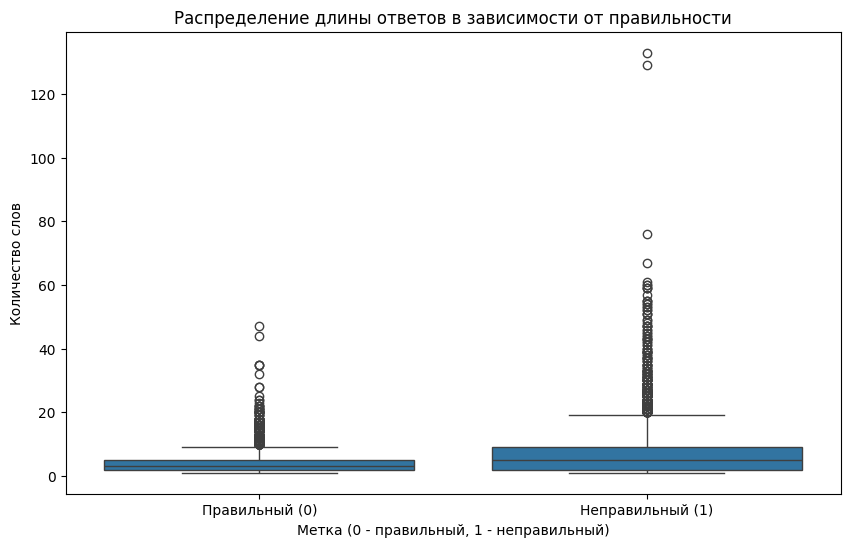

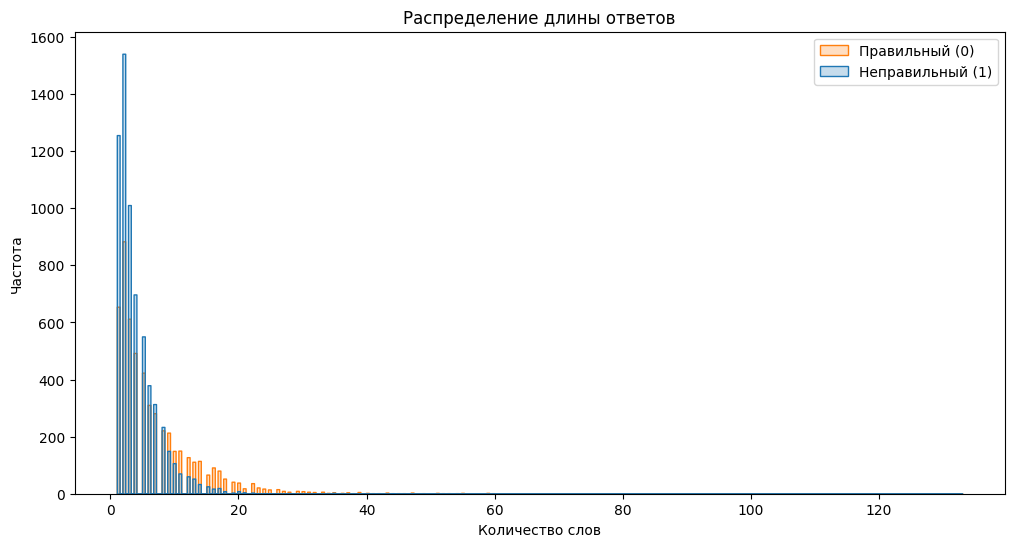


Разница в средней длине ответов: 55.10%
Наблюдается значительная разница в длине между правильными и неправильными ответами
       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   

In [128]:
print(len_corr_diff_analayzer(answers_train))

#### Val


Длина ответов в зависимости от правильности:

Правильные ответы (label=0):
Среднее количество слов: 4.29
Медианное количество слов: 3.0
Минимальное количество слов: 1.0
Максимальное количество слов: 27.0

Неправильные ответы (label=1):
Среднее количество слов: 6.95
Медианное количество слов: 5.0
Минимальное количество слов: 1.0
Максимальное количество слов: 59.0


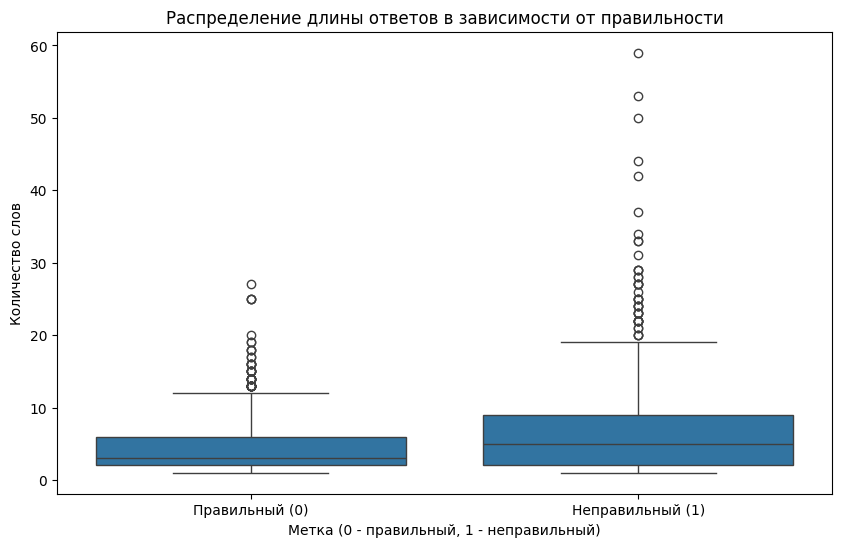

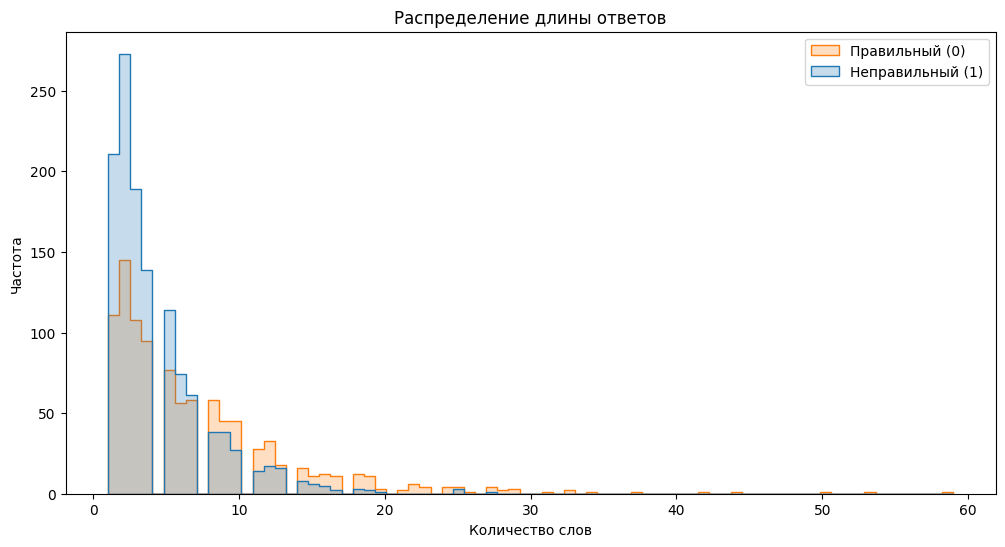


Разница в средней длине ответов: 47.19%
Наблюдается значительная разница в длине между правильными и неправильными ответами
      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, чт

In [129]:
print(len_corr_diff_analayzer(answers_val))

## Взаимосвязи между текстами, вопросами и ответами

### Анализ взаимосвязи между вопросам и ответами

In [130]:
def q_a_ans_analayzer(questions_df, answers_df):
    """
    Анализирует взаимосвязи между вопросами и ответами.
    """
    qa_data = pd.merge(
        questions_df,
        answers_df,
        on=['passage_id', 'question_id'],
        how='inner'
    )

    answers_per_question = qa_data.groupby(['passage_id', 'question_id']).size().reset_index(name='answer_count')

    print(f"Общее количество пар вопрос-ответ: {len(qa_data)}")
    print(f"Среднее количество ответов на вопрос: {answers_per_question['answer_count'].mean():.2f}")
    print(f"Максимальное количество ответов на вопрос: {answers_per_question['answer_count'].max()}")

    plt.figure(figsize=(10, 6))
    sns.countplot(x='answer_count', data=answers_per_question)
    plt.title('Распределение количества ответов на вопрос')
    plt.xlabel('Количество ответов')
    plt.ylabel('Количество вопросов')
    plt.show()

    if 'question_text' in qa_data.columns and 'answer_text' in qa_data.columns:
        qa_data['question_length'] = qa_data['question_text'].apply(lambda x: len(str(x).split()))
        qa_data['answer_length'] = qa_data['answer_text'].apply(lambda x: len(str(x).split()))

        correlation = qa_data['question_length'].corr(qa_data['answer_length'])

        print(f"\nКорреляция между длиной вопроса и длиной ответа: {correlation:.4f}")

        plt.figure(figsize=(10, 6))
        plt.scatter(qa_data['question_length'], qa_data['answer_length'], alpha=0.5)
        plt.title('Взаимосвязь между длиной вопроса и длиной ответа')
        plt.xlabel('Длина вопроса (слов)')
        plt.ylabel('Длина ответа (слов)')

        z = np.polyfit(qa_data['question_length'], qa_data['answer_length'], 1)
        p = np.poly1d(z)
        plt.plot(qa_data['question_length'], p(qa_data['question_length']), "r--")

        plt.show()

    if 'question_type' in qa_data.columns and 'label' in qa_data.columns:
        print("\nДоля правильных ответов по типам вопросов:")

        correct_by_type = qa_data.groupby('question_type')['label'].apply(
            lambda x: (x == 0).mean() * 100
        ).sort_values(ascending=False)

        for q_type, correct_percentage in correct_by_type.items():
            print(f"{q_type}: {correct_percentage:.2f}%")

        plt.figure(figsize=(12, 6))
        sns.barplot(x=correct_by_type.index, y=correct_by_type.values)
        plt.title('Доля правильных ответов по типам вопросов')
        plt.xlabel('Тип вопроса')
        plt.ylabel('Процент правильных ответов')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return qa_data

#### Train

Общее количество пар вопрос-ответ: 11950
Среднее количество ответов на вопрос: 4.12
Максимальное количество ответов на вопрос: 12


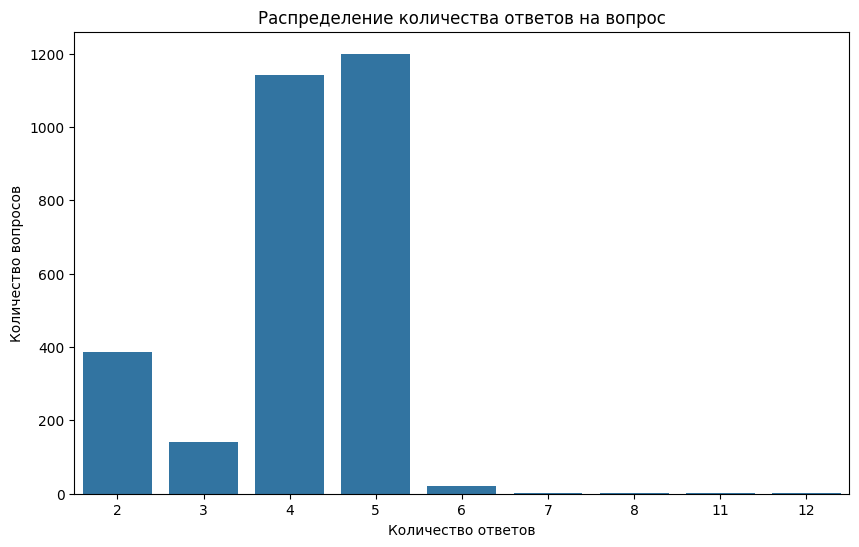


Корреляция между длиной вопроса и длиной ответа: -0.0015


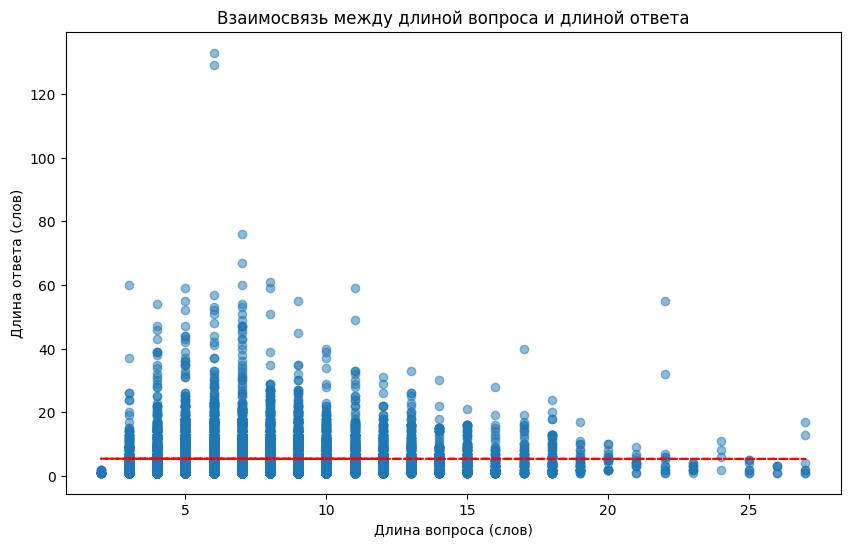


Доля правильных ответов по типам вопросов:
Чей: 56.90%
Сколько: 56.67%
Где: 56.40%
Кто: 55.71%
Когда: 55.56%
Другое: 55.34%
Как: 55.14%
Почему: 54.29%
Какой: 54.06%
Что: 53.20%


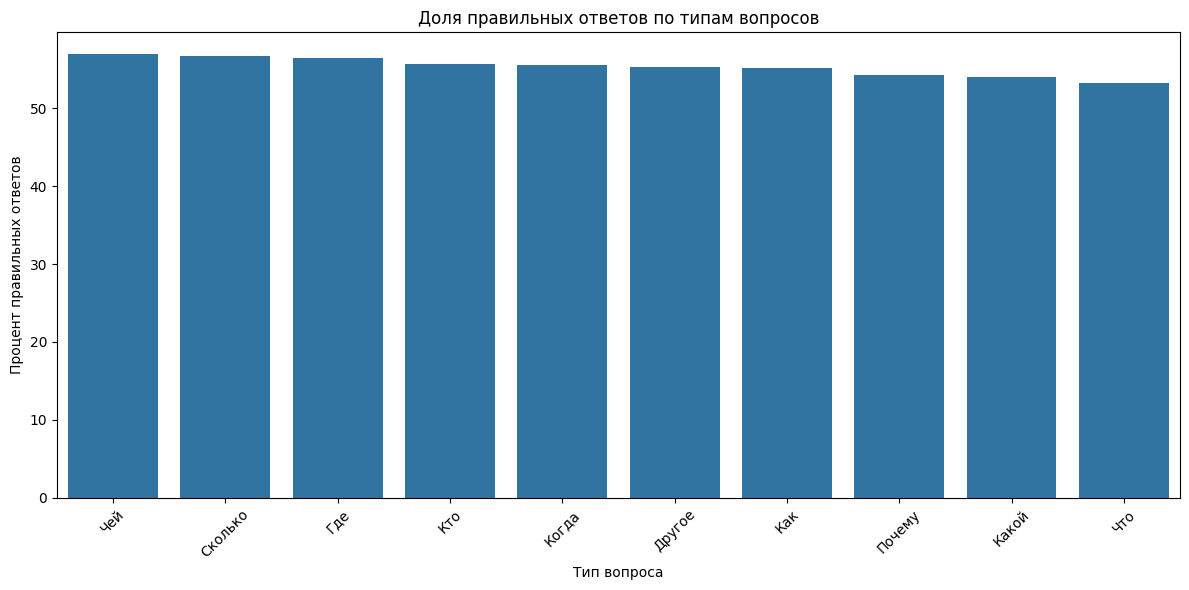

       passage_id  question_id  \
0               0            0   
1               0            0   
2               0            0   
3               0            1   
4               0            1   
...           ...          ...   
11945         499         2896   
11946         499         2896   
11947         499         2896   
11948         499         2896   
11949         499         2896   

                                           question_text  question_word_count  \
0                                      Где бегала шпана?                    3   
1                                      Где бегала шпана?                    3   
2                                      Где бегала шпана?                    3   
3                            Почему Люда ударила Артема?                    4   
4                            Почему Люда ударила Артема?                    4   
...                                                  ...                  ...   
11945  Как проявляется л

In [131]:

print(q_a_ans_analayzer(questions_train,answers_train))

#### Val

Общее количество пар вопрос-ответ: 2235
Среднее количество ответов на вопрос: 4.22
Максимальное количество ответов на вопрос: 7


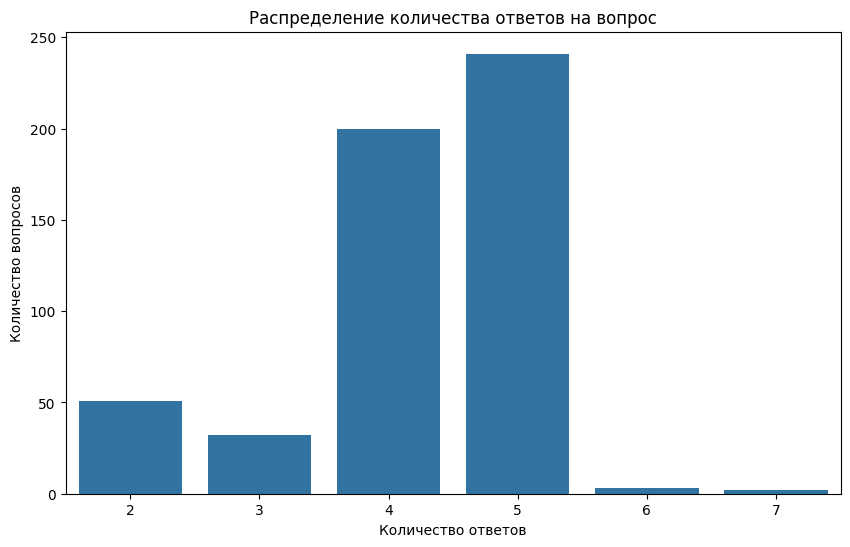


Корреляция между длиной вопроса и длиной ответа: 0.0319


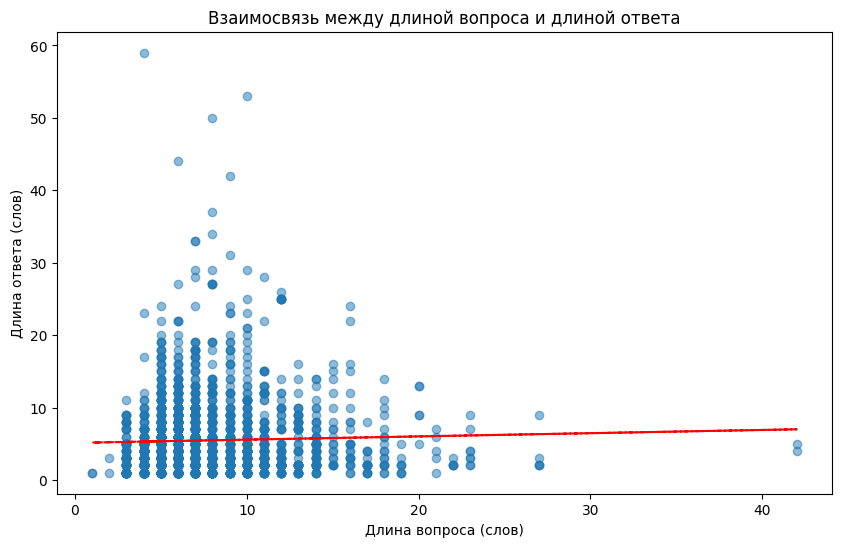


Доля правильных ответов по типам вопросов:
Почему: 57.23%
Где: 56.35%
Кто: 56.35%
Какой: 56.11%
Как: 55.61%
Другое: 55.47%
Что: 54.49%
Сколько: 53.62%
Когда: 52.17%


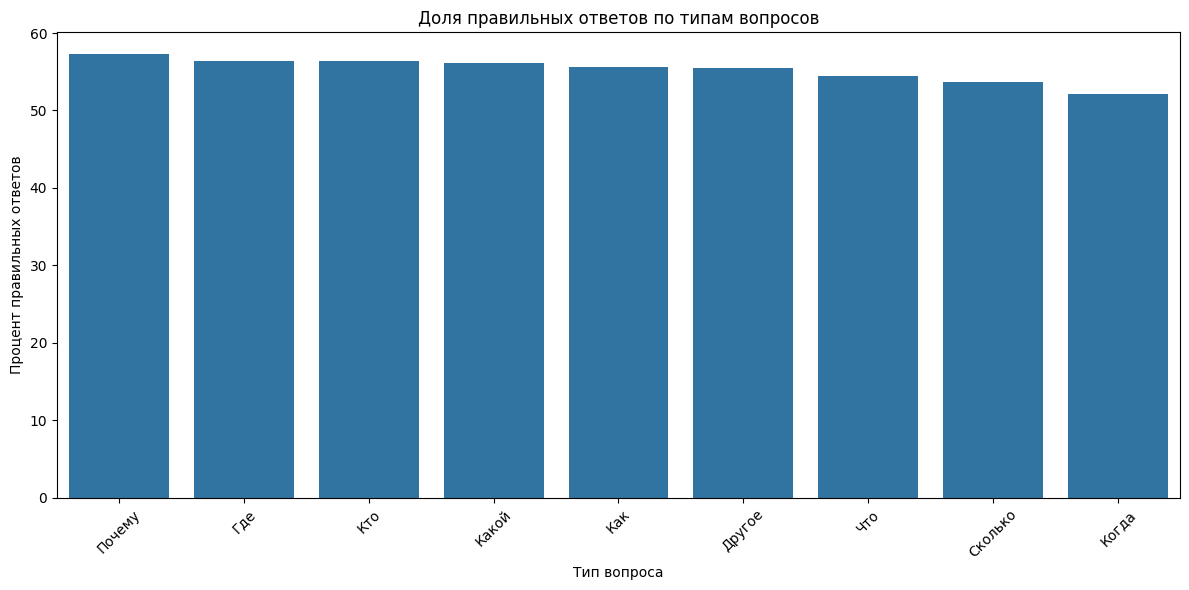

      passage_id  question_id                               question_text  \
0              0            0  Почему Солженицына перевозили спецконвоем?   
1              0            0  Почему Солженицына перевозили спецконвоем?   
2              0            0  Почему Солженицына перевозили спецконвоем?   
3              0            0  Почему Солженицына перевозили спецконвоем?   
4              0            0  Почему Солженицына перевозили спецконвоем?   
...          ...          ...                                         ...   
2230          99          528              За что осуждён Рокко Маньотта?   
2231          99          528              За что осуждён Рокко Маньотта?   
2232          99          528              За что осуждён Рокко Маньотта?   
2233          99          528              За что осуждён Рокко Маньотта?   
2234          99          528              За что осуждён Рокко Маньотта?   

      question_word_count  question_char_count question_type  \
0          

In [132]:
print(q_a_ans_analayzer(questions_val,answers_val))

#### Test

Общее количество пар вопрос-ответ: 7614
Среднее количество ответов на вопрос: 4.20
Максимальное количество ответов на вопрос: 10


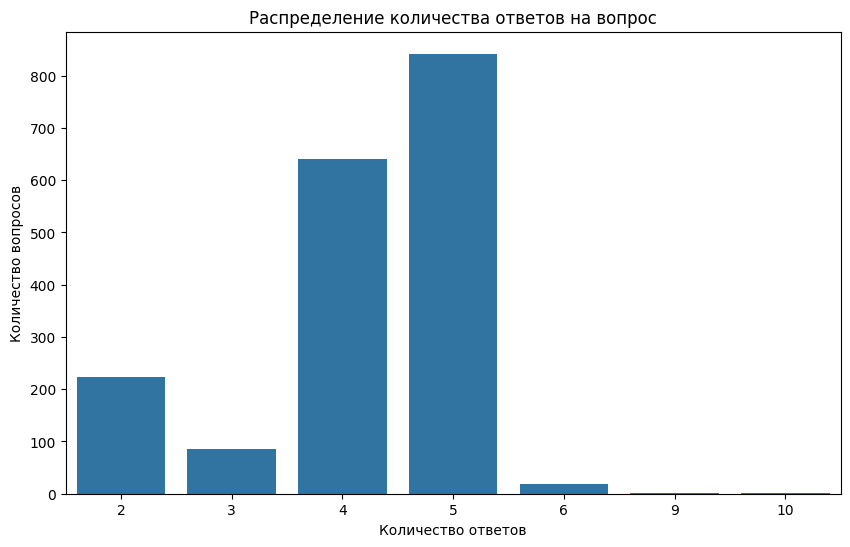


Корреляция между длиной вопроса и длиной ответа: 0.0901


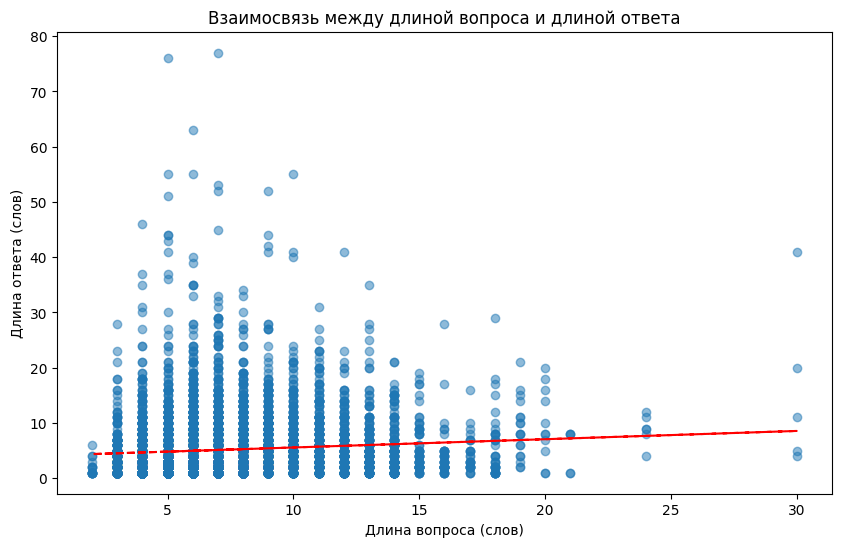

      passage_id  question_id  \
0              0            0   
1              0            0   
2              0            0   
3              0            0   
4              0            1   
...          ...          ...   
7609         321         1811   
7610         321         1812   
7611         321         1812   
7612         321         1812   
7613         321         1812   

                                          question_text  question_word_count  \
0                             О чем дневник Анны Франк?                    5   
1                             О чем дневник Анны Франк?                    5   
2                             О чем дневник Анны Франк?                    5   
3                             О чем дневник Анны Франк?                    5   
4                Каким будет приложение Anne Frank App?                    6   
...                                                 ...                  ...   
7609                В чём обвинил суд Русла

In [133]:
print(q_a_ans_analayzer(questions_test,answers_test))

### Анализ взаимосвязи между текстами и вопросами

In [134]:
def t_q_rel_analayzer(passages_df, questions_df):
    """
    Анализирует взаимосвязи между текстами документов и вопросами к ним.
    """
    tq_data = pd.merge(
        passages_df,
        questions_df,
        on='passage_id',
        how='inner'
    )

    questions_per_passage = tq_data.groupby('passage_id').size().reset_index(name='question_count')

    print(f"Общее количество пар текст-вопрос: {len(tq_data)}")
    print(f"Среднее количество вопросов на текст: {questions_per_passage['question_count'].mean():.2f}")
    print(f"Максимальное количество вопросов на текст: {questions_per_passage['question_count'].max()}")
    print(f"Минимальное количество вопросов на текст: {questions_per_passage['question_count'].min()}")

    plt.figure(figsize=(10, 6))
    sns.countplot(x='question_count', data=questions_per_passage)
    plt.title('Распределение количества вопросов на текст')
    plt.xlabel('Количество вопросов')
    plt.ylabel('Количество текстов')
    plt.show()

    if 'passage_text' in tq_data.columns:
        tq_data['passage_length'] = tq_data['passage_text'].apply(lambda x: len(str(x).split()))

        passage_data = tq_data.groupby('passage_id').agg({
            'passage_length': 'first',
            'question_id': 'count'
        }).rename(columns={'question_id': 'question_count'})

        correlation = passage_data['passage_length'].corr(passage_data['question_count'])

        print(f"\nКорреляция между длиной текста и количеством вопросов: {correlation:.4f}")

        plt.figure(figsize=(10, 6))
        plt.scatter(passage_data['passage_length'], passage_data['question_count'], alpha=0.5)
        plt.title('Взаимосвязь между длиной текста и количеством вопросов')
        plt.xlabel('Длина текста (слов)')
        plt.ylabel('Количество вопросов')

        z = np.polyfit(passage_data['passage_length'], passage_data['question_count'], 1)
        p = np.poly1d(z)
        plt.plot(passage_data['passage_length'], p(passage_data['passage_length']), "r--")

        plt.show()

    if 'question_type' in tq_data.columns:
        question_type_counts = tq_data['question_type'].value_counts()

        print("\nРаспределение типов вопросов:")
        for q_type, count in question_type_counts.items():
            percentage = count / len(tq_data) * 100
            print(f"{q_type}: {count} ({percentage:.2f}%)")


        plt.figure(figsize=(12, 6))
        sns.countplot(y='question_type', data=tq_data, order=question_type_counts.index)
        plt.title('Распределение типов вопросов')
        plt.xlabel('Количество')
        plt.ylabel('Тип вопроса')
        plt.tight_layout()
        plt.show()

    return tq_data

#### Train

Общее количество пар текст-вопрос: 2897
Среднее количество вопросов на текст: 5.79
Максимальное количество вопросов на текст: 14
Минимальное количество вопросов на текст: 1


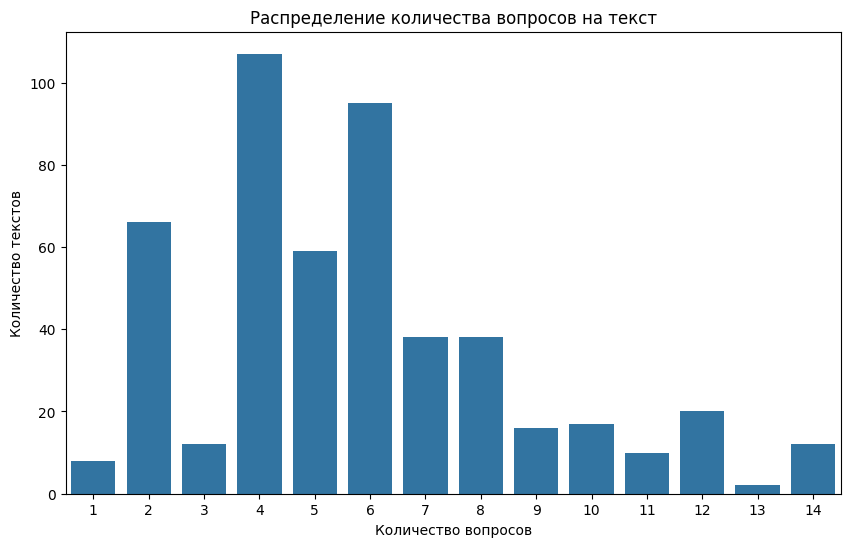


Корреляция между длиной текста и количеством вопросов: -0.0075


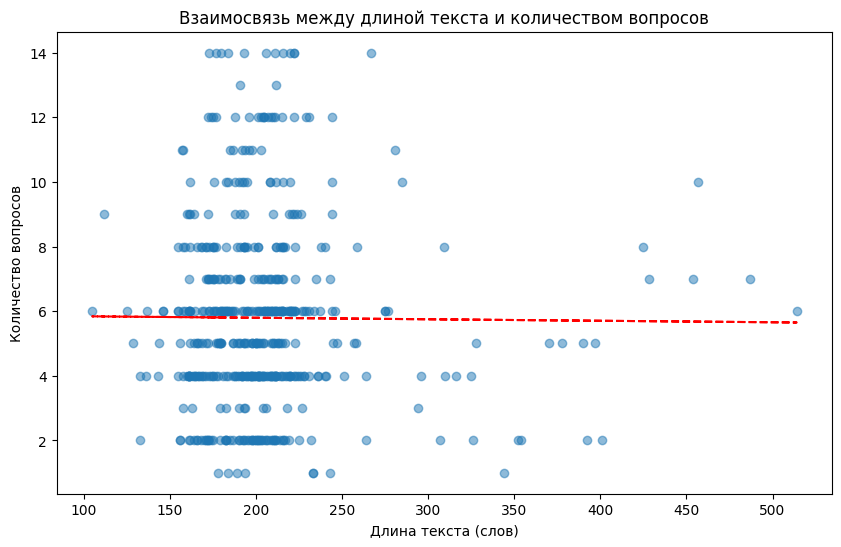


Распределение типов вопросов:
Другое: 1008 (34.79%)
Что: 484 (16.71%)
Кто: 339 (11.70%)
Какой: 276 (9.53%)
Как: 240 (8.28%)
Почему: 175 (6.04%)
Где: 132 (4.56%)
Сколько: 121 (4.18%)
Когда: 96 (3.31%)
Чей: 26 (0.90%)


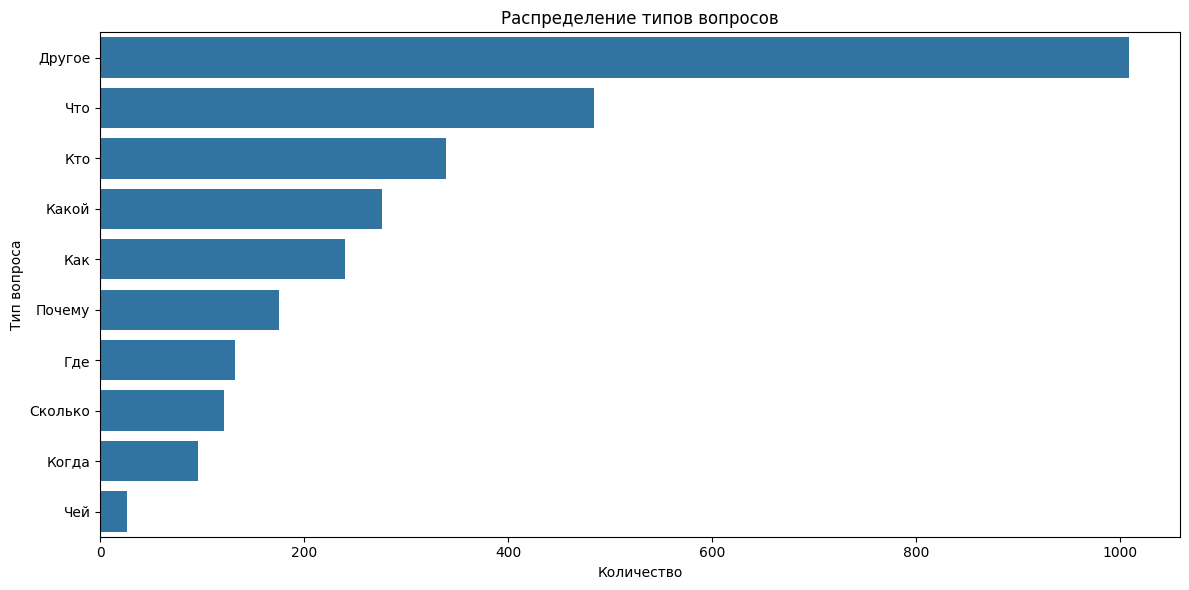

      passage_id                                       passage_text  \
0              0  (1) Но люди не могут существовать без природы,...   
1              0  (1) Но люди не могут существовать без природы,...   
2              0  (1) Но люди не могут существовать без природы,...   
3              0  (1) Но люди не могут существовать без природы,...   
4              0  (1) Но люди не могут существовать без природы,...   
...          ...                                                ...   
2892         498  (1) Каспийская флотилия, оперативное объединен...   
2893         499  (1) Известный американский боец смешанных един...   
2894         499  (1) Известный американский боец смешанных един...   
2895         499  (1) Известный американский боец смешанных един...   
2896         499  (1) Известный американский боец смешанных един...   

      word_count  sentence_count  avg_sentence_length  question_id  \
0            234              10                23.40            0   
1      

In [135]:
print(t_q_rel_analayzer(passages_train, questions_train))

#### Val

Общее количество пар текст-вопрос: 529
Среднее количество вопросов на текст: 5.29
Максимальное количество вопросов на текст: 14
Минимальное количество вопросов на текст: 2


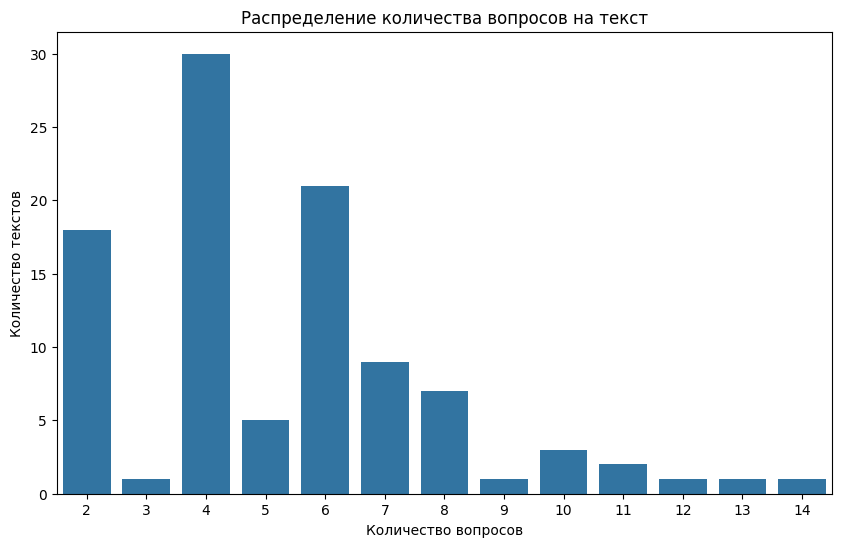


Корреляция между длиной текста и количеством вопросов: 0.0008


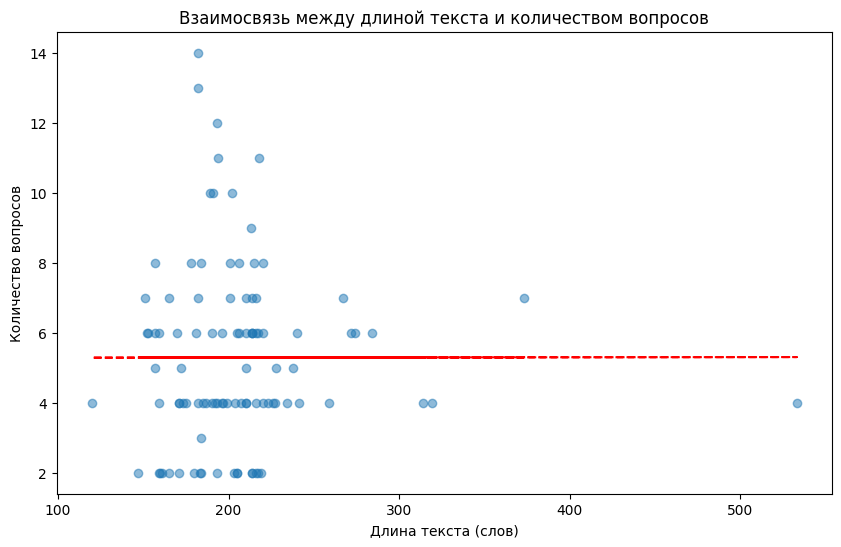


Распределение типов вопросов:
Другое: 177 (33.46%)
Что: 80 (15.12%)
Какой: 63 (11.91%)
Кто: 60 (11.34%)
Как: 51 (9.64%)
Почему: 39 (7.37%)
Где: 31 (5.86%)
Сколько: 17 (3.21%)
Когда: 11 (2.08%)


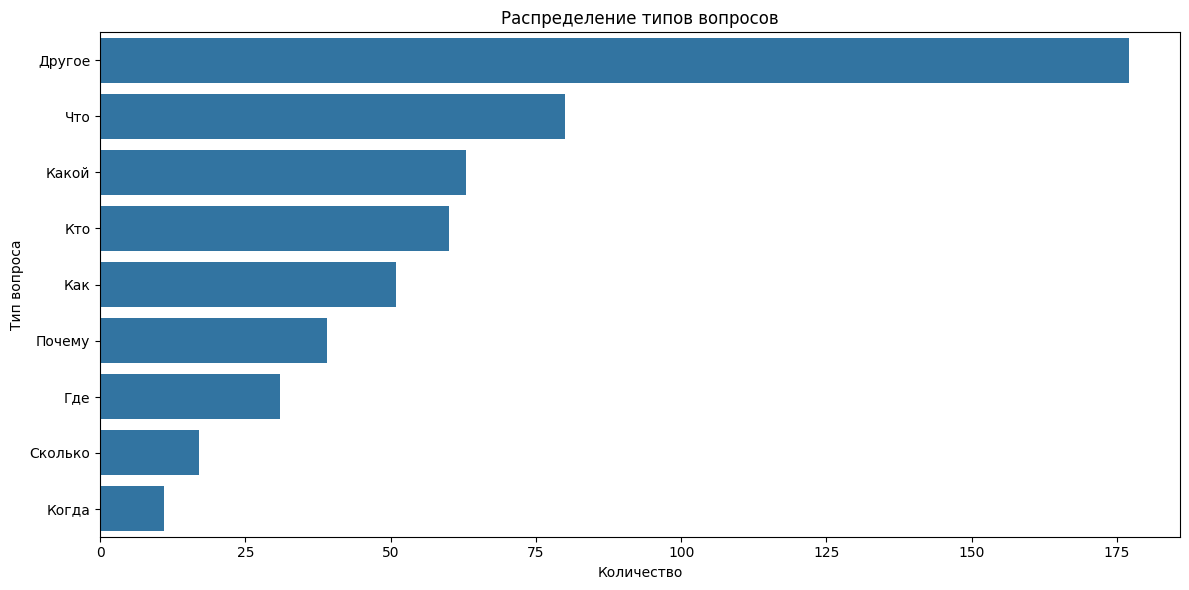

     passage_id                                       passage_text  \
0             0  (1) Самый первый «остров» Архипелага возник в ...   
1             0  (1) Самый первый «остров» Архипелага возник в ...   
2             1  (1) Сбербанк обратился в Арбитражный суд Санкт...   
3             1  (1) Сбербанк обратился в Арбитражный суд Санкт...   
4             2  (1)Стала она слепнуть. (2)Текст расплывается п...   
..          ...                                                ...   
524          99  (1) Канадский порноактер Лука Рокко Маньотта, ...   
525          99  (1) Канадский порноактер Лука Рокко Маньотта, ...   
526          99  (1) Канадский порноактер Лука Рокко Маньотта, ...   
527          99  (1) Канадский порноактер Лука Рокко Маньотта, ...   
528          99  (1) Канадский порноактер Лука Рокко Маньотта, ...   

     word_count  sentence_count  avg_sentence_length  question_id  \
0           207              12              17.2500            0   
1           207      

In [136]:
print(t_q_rel_analayzer(passages_val, questions_val))

#### Test

Общее количество пар текст-вопрос: 1813
Среднее количество вопросов на текст: 5.63
Максимальное количество вопросов на текст: 19
Минимальное количество вопросов на текст: 1


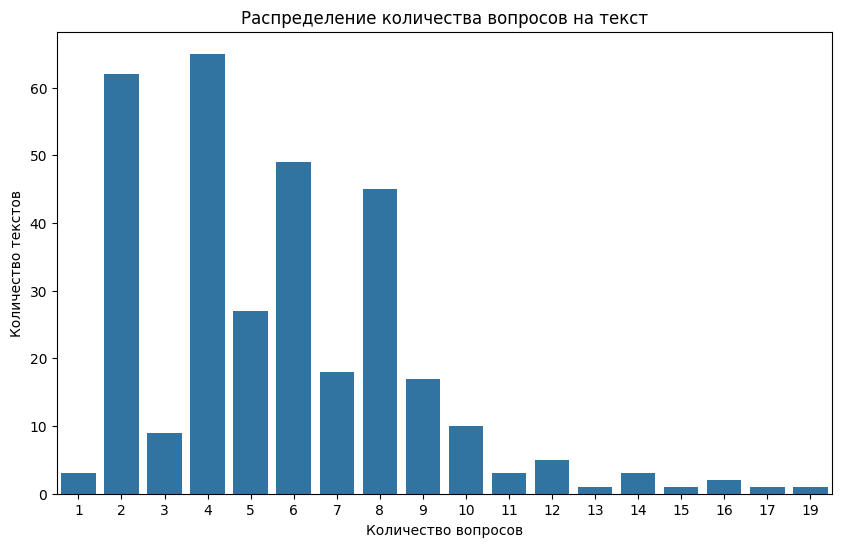


Корреляция между длиной текста и количеством вопросов: -0.0209


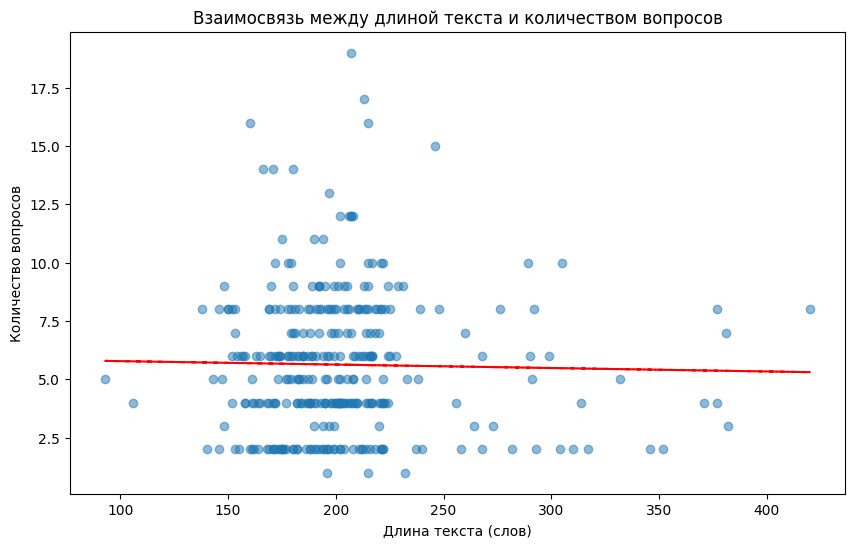


Распределение типов вопросов:
Другое: 579 (31.94%)
Что: 373 (20.57%)
Кто: 245 (13.51%)
Какой: 183 (10.09%)
Как: 140 (7.72%)
Почему: 93 (5.13%)
Где: 82 (4.52%)
Когда: 56 (3.09%)
Сколько: 51 (2.81%)
Чей: 11 (0.61%)


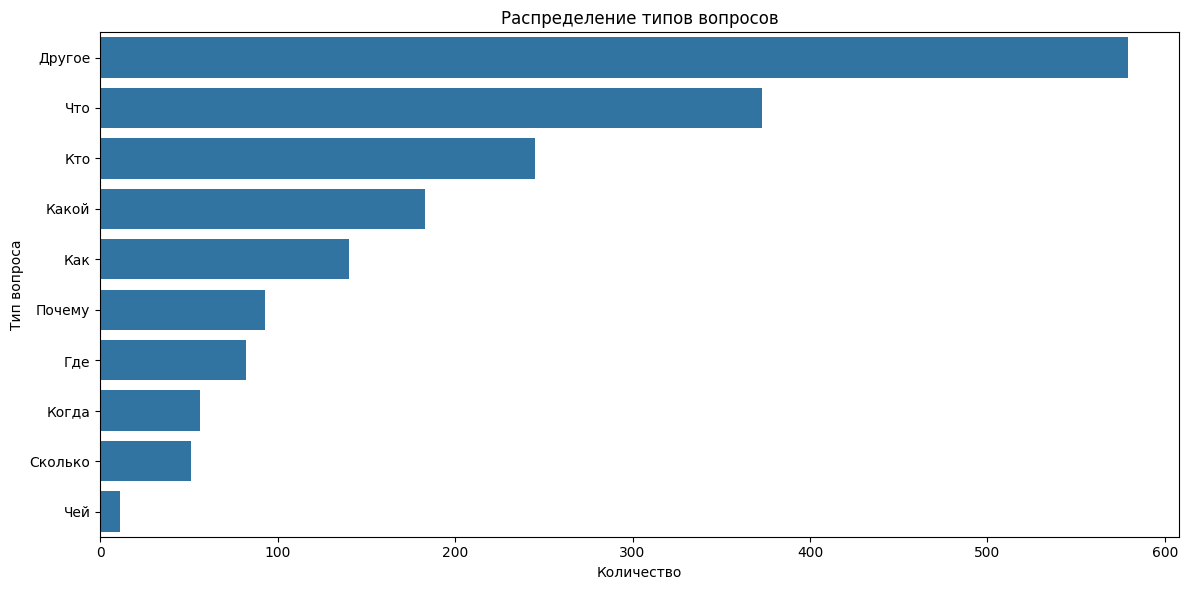

      passage_id                                       passage_text  \
0              0  (1) Издательство Viking Press совместно с комп...   
1              0  (1) Издательство Viking Press совместно с комп...   
2              0  (1) Издательство Viking Press совместно с комп...   
3              0  (1) Издательство Viking Press совместно с комп...   
4              0  (1) Издательство Viking Press совместно с комп...   
...          ...                                                ...   
1808         320  (1) Жил-был маленький медвежонок. (2) У него б...   
1809         320  (1) Жил-был маленький медвежонок. (2) У него б...   
1810         320  (1) Жил-был маленький медвежонок. (2) У него б...   
1811         321  (1) В Латвии вынесен приговор владельцу модель...   
1812         321  (1) В Латвии вынесен приговор владельцу модель...   

      word_count  sentence_count  avg_sentence_length  question_id  \
0            282              15            18.800000            0   
1      

In [137]:
print(t_q_rel_analayzer(passages_test, questions_test))

### Анализ положения вопросов в тексте и его связь с правильным ответом

In [138]:
def q_in_text_pos_analayzer(passages_df, questions_df, answers_df):
    """
    Анализирует положение вопроса в тексте и его связь с правильным ответом.
    """
    merged_data = pd.merge(
        answers_df,
        questions_df[['passage_id', 'question_id', 'question_text']],
        on=['passage_id', 'question_id'],
        how='inner'
    )

    merged_data = pd.merge(
        merged_data,
        passages_df[['passage_id', 'passage_text']],
        on='passage_id',
        how='inner'
    )

    def find_question_position(row):
        passage = str(row['passage_text']).lower()
        question_text = str(row['question_text']).lower()

        question_words = question_text.split()
        keywords = [word for word in question_words if word not in russian_stopwords and len(word) > 3]

        if not keywords:
            return 'unknown'

        passage_words = passage.split()
        passage_length = len(passage_words)

        if passage_length <= 1:
            return 'unknown'

        first_third = ' '.join(passage_words[:passage_length//3])
        middle_third = ' '.join(passage_words[passage_length//3:2*passage_length//3])
        last_third = ' '.join(passage_words[2*passage_length//3:])

        first_matches = sum(1 for word in keywords if word in first_third)
        middle_matches = sum(1 for word in keywords if word in middle_third)
        last_matches = sum(1 for word in keywords if word in last_third)

        max_matches = max(first_matches, middle_matches, last_matches)

        if max_matches == 0:
            return 'unknown'
        elif first_matches == max_matches:
            return 'beginning'
        elif middle_matches == max_matches:
            return 'middle'
        else:
            return 'end'

    merged_data['question_position'] = merged_data.apply(find_question_position, axis=1)

    position_counts = merged_data['question_position'].value_counts()
    position_percentages = (position_counts / len(merged_data) * 100).round(2)

    print("\nРаспределение положения вопросов в тексте:")
    for position, count in position_counts.items():
        percentage = position_percentages[position]
        position_name = {
            'beginning': 'Начало текста',
            'middle': 'Середина текста',
            'end': 'Конец текста',
            'unknown': 'Не определено'
        }.get(position, position)
        print(f"{position_name}: {count} ({percentage}%)")

    plt.figure(figsize=(10, 6))
    position_order = ['beginning', 'middle', 'end', 'unknown']
    position_order = [pos for pos in position_order if pos in position_counts.index]
    sns.countplot(x='question_position', data=merged_data, order=position_order)
    plt.title('Распределение положения вопросов в тексте')
    plt.xlabel('Положение')
    plt.ylabel('Количество')
    plt.xticks(range(len(position_order)), ['Начало', 'Середина', 'Конец', 'Не определено'][:len(position_order)])
    plt.show()

    if 'label' in merged_data.columns:
        correct_by_position = merged_data.groupby('question_position')['label'].apply(
            lambda x: (x == 0).mean() * 100
        ).reindex(position_order)

        print("\nДоля правильных ответов в зависимости от положения вопроса в тексте:")
        for position, percentage in correct_by_position.items():
            position_name = {
                'beginning': 'Начало текста',
                'middle': 'Середина текста',
                'end': 'Конец текста',
                'unknown': 'Не определено'
            }.get(position, position)
            print(f"{position_name}: {percentage:.2f}%")

        plt.figure(figsize=(10, 6))
        sns.barplot(x=correct_by_position.index, y=correct_by_position.values, order=position_order)
        plt.title('Доля правильных ответов в зависимости от положения вопроса')
        plt.xlabel('Положение')
        plt.ylabel('Процент правильных ответов')
        plt.xticks(range(len(position_order)), ['Начало', 'Середина', 'Конец', 'Не определено'][:len(position_order)])
        plt.show()

    return merged_data

#### Train


Распределение положения вопросов в тексте:
Начало текста: 5657 (47.34%)
Середина текста: 2389 (19.99%)
Конец текста: 2145 (17.95%)
Не определено: 1759 (14.72%)


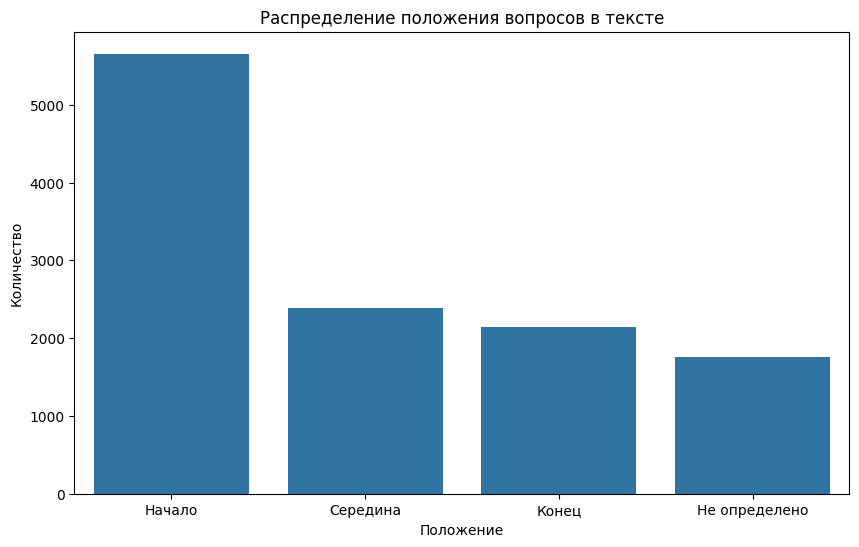


Доля правильных ответов в зависимости от положения вопроса в тексте:
Начало текста: 54.94%
Середина текста: 55.38%
Конец текста: 55.71%
Не определено: 53.55%


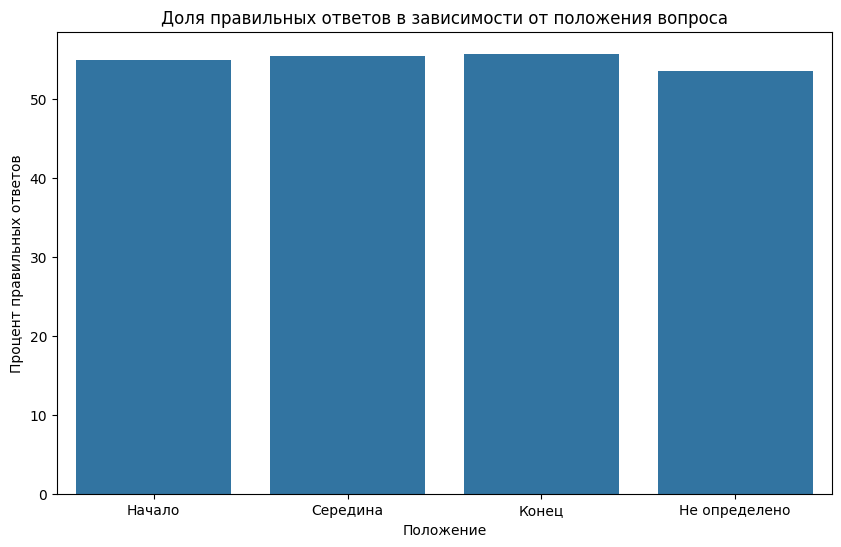

       passage_id  question_id  answer_id  \
0               0            0          0   
1               0            0          1   
2               0            0          2   
3               0            1          3   
4               0            1          4   
...           ...          ...        ...   
11945         499         2896      11945   
11946         499         2896      11946   
11947         499         2896      11947   
11948         499         2896      11948   
11949         499         2896      11949   

                                             answer_text  label  \
0                                               В парке.      1   
1                                                В лесу.      0   
2                                        Около подъезда.      0   
3                                    Он к ней приставал.      1   
4                                        Он ее оскорбил.      0   
...                                                  ... 

In [139]:
print(q_in_text_pos_analayzer(passages_train, questions_train, answers_train))

#### Val


Распределение положения вопросов в тексте:
Начало текста: 1099 (49.17%)
Середина текста: 462 (20.67%)
Не определено: 338 (15.12%)
Конец текста: 336 (15.03%)


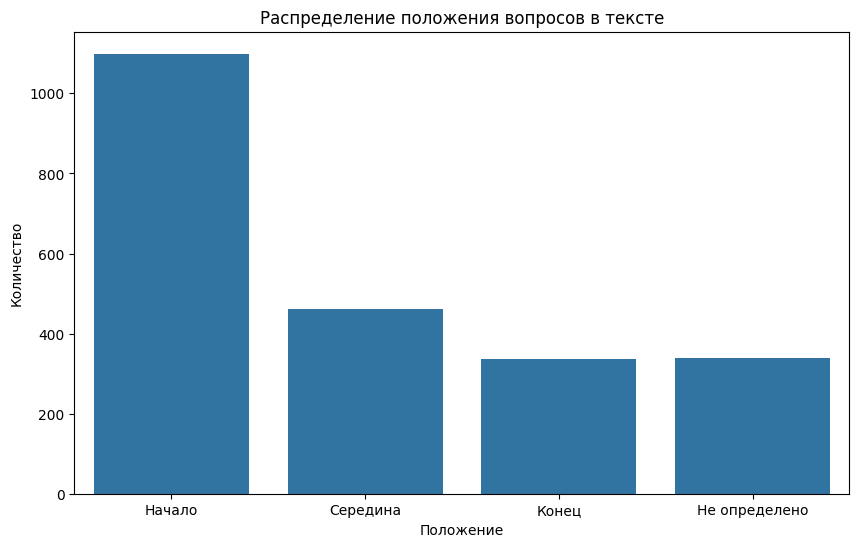


Доля правильных ответов в зависимости от положения вопроса в тексте:
Начало текста: 55.51%
Середина текста: 55.63%
Конец текста: 56.55%
Не определено: 54.73%


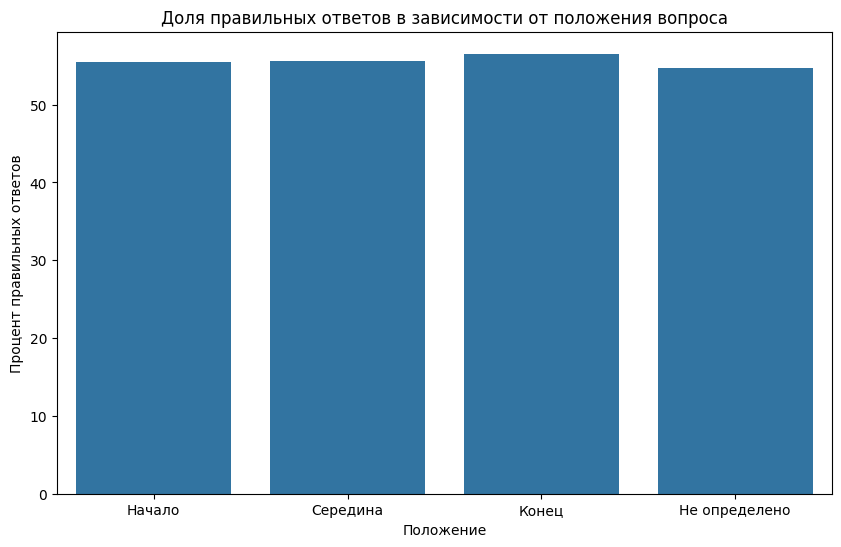

      passage_id  question_id  answer_id  \
0              0            0          0   
1              0            0          1   
2              0            0          2   
3              0            0          3   
4              0            0          4   
...          ...          ...        ...   
2230          99          528       2230   
2231          99          528       2231   
2232          99          528       2232   
2233          99          528       2233   
2234          99          528       2234   

                                            answer_text  label  \
0              Так перевозили особо важных заключенных.      1   
1                           Потому, что был эмигрантом.      0   
2               Потому, что он сам вырыл себе землянку.      0   
3     Потому, что он побывал на пересылке Красная Пр...      0   
4     Потому, что он был особо важным заключённым и ...      1   
...                                                 ...    ...   
2230     

In [140]:
print(q_in_text_pos_analayzer(passages_val, questions_val, answers_val))

## Визуализации

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec

def tsne_visual(passages_df, questions_df, answers_df, sample_size=2000):
    """
    Создает t-SNE визуализацию векторных представлений текстов, вопросов и ответов.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set(font_scale=1.2)



    def preprocess_text(text):
        text = str(text).lower()
        text = ' '.join(text.split())
        return text

    passage_samples = passages_df['passage_text'].sample(min(sample_size, len(passages_df)), random_state=52).apply(preprocess_text)
    question_samples = questions_df['question_text'].sample(min(sample_size, len(questions_df)), random_state=52).apply(preprocess_text)
    answer_samples = answers_df['answer_text'].sample(min(sample_size, len(answers_df)), random_state=52).apply(preprocess_text)

    all_texts = pd.concat([passage_samples, question_samples, answer_samples]).reset_index(drop=True)

    vectorizer = TfidfVectorizer(max_features=300)
    vectors = vectorizer.fit_transform(all_texts)

    X = vectors.toarray()

    labels = np.array(['Текст'] * len(passage_samples) +
                      ['Вопрос'] * len(question_samples) +
                      ['Ответ'] * len(answer_samples))

    print("Применение t-SNE для снижения размерности. Это может занять некоторое время...")
    tsne = TSNE(n_components=2, random_state=52, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(X)

    tsne_df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'category': labels
    })

    color_palette = {
        'Текст': '#3498db',
        'Вопрос': '#e74c3c',
        'Ответ': '#2ecc71'
    }

    plt.figure(figsize=(14, 10))

    sns.scatterplot(
        x='x', y='y',
        hue='category',
        palette=color_palette,
        data=tsne_df,
        alpha=0.7,
        s=70,
        edgecolor='w',
        linewidth=0.5
    )

    plt.title('t-SNE визуализация векторных представлений', fontsize=20)
    plt.xlabel('t-SNE компонента 1', fontsize=14)
    plt.ylabel('t-SNE компонента 2', fontsize=14)
    plt.legend(title='Категория', fontsize=12, title_fontsize=14)

    info_text = (
        f"Визуализация на основе TF-IDF векторов\n"
        f"Тексты: {len(passage_samples)}\n"
        f"Вопросы: {len(question_samples)}\n"
        f"Ответы: {len(answer_samples)}"
    )
    plt.annotate(
        info_text,
        xy=(0.02, 0.02),
        xycoords='figure fraction',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
        fontsize=12
    )

    plt.tight_layout()

    plt.show()

    print("t-SNE визуализация создана!")

    return plt

Применение t-SNE для снижения размерности. Это может занять некоторое время...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


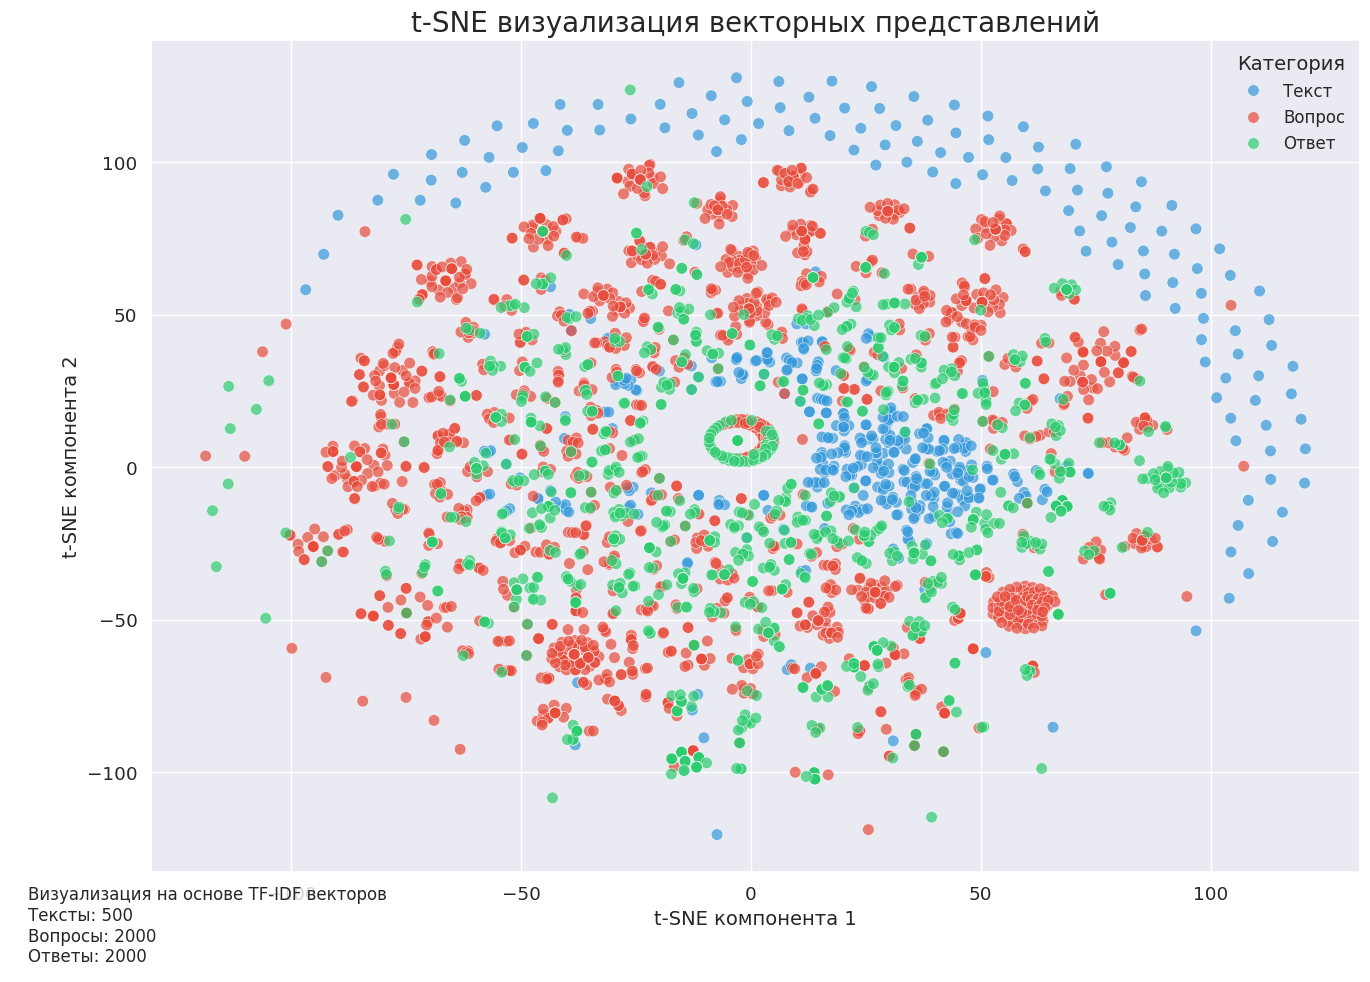

t-SNE визуализация создана!
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>


In [144]:
print(tsne_visual(passages_train, questions_train, answers_train))

Применение t-SNE для снижения размерности. Это может занять некоторое время...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


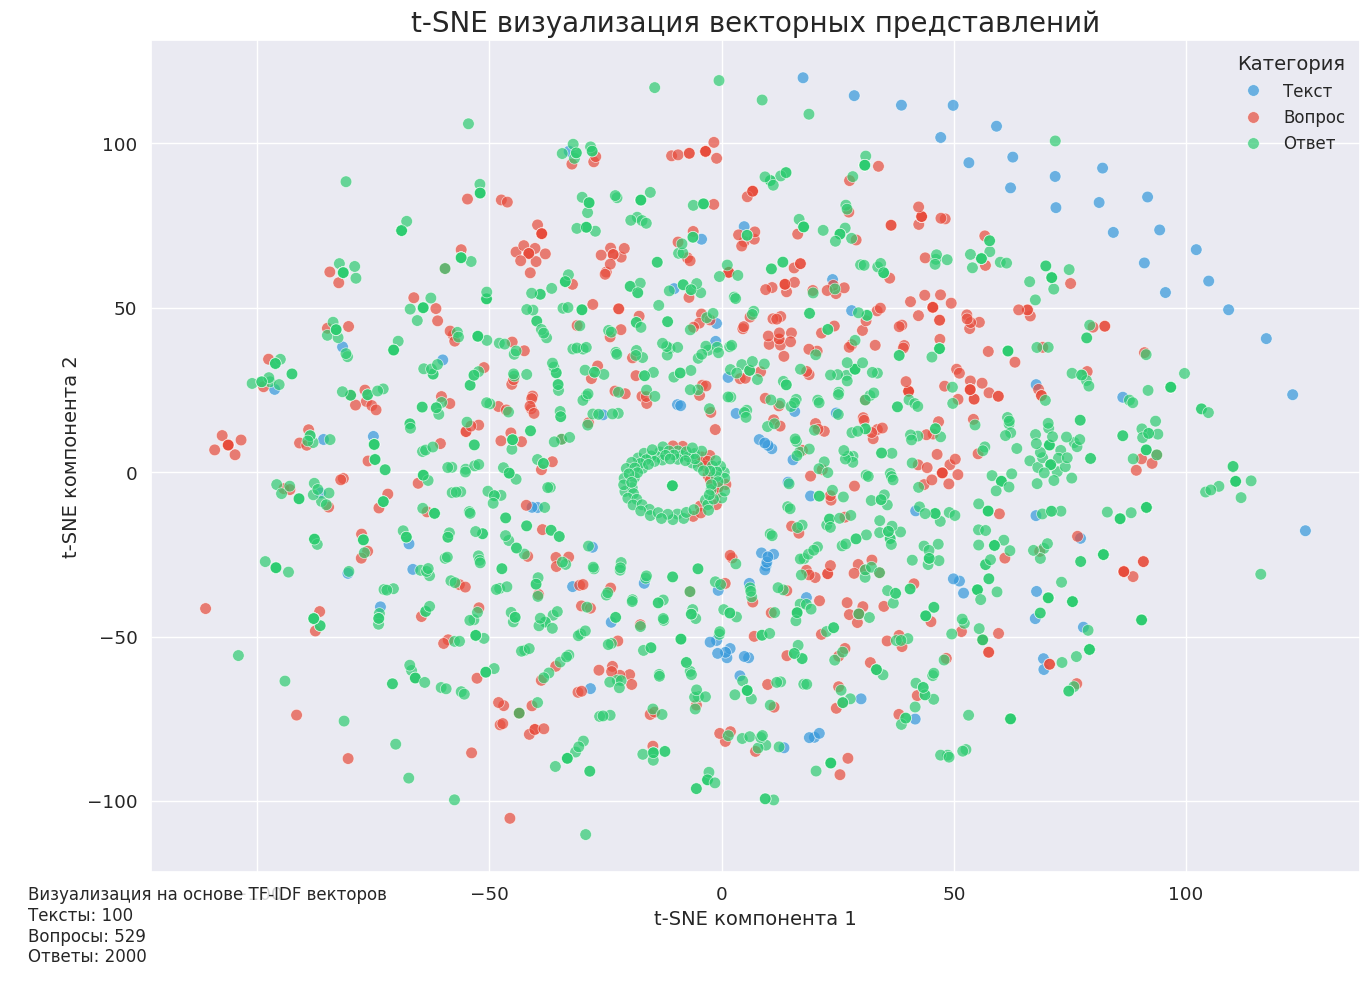

t-SNE визуализация создана!
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>


In [145]:
print(tsne_visual(passages_val, questions_val, answers_val))

Применение t-SNE для снижения размерности. Это может занять некоторое время...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


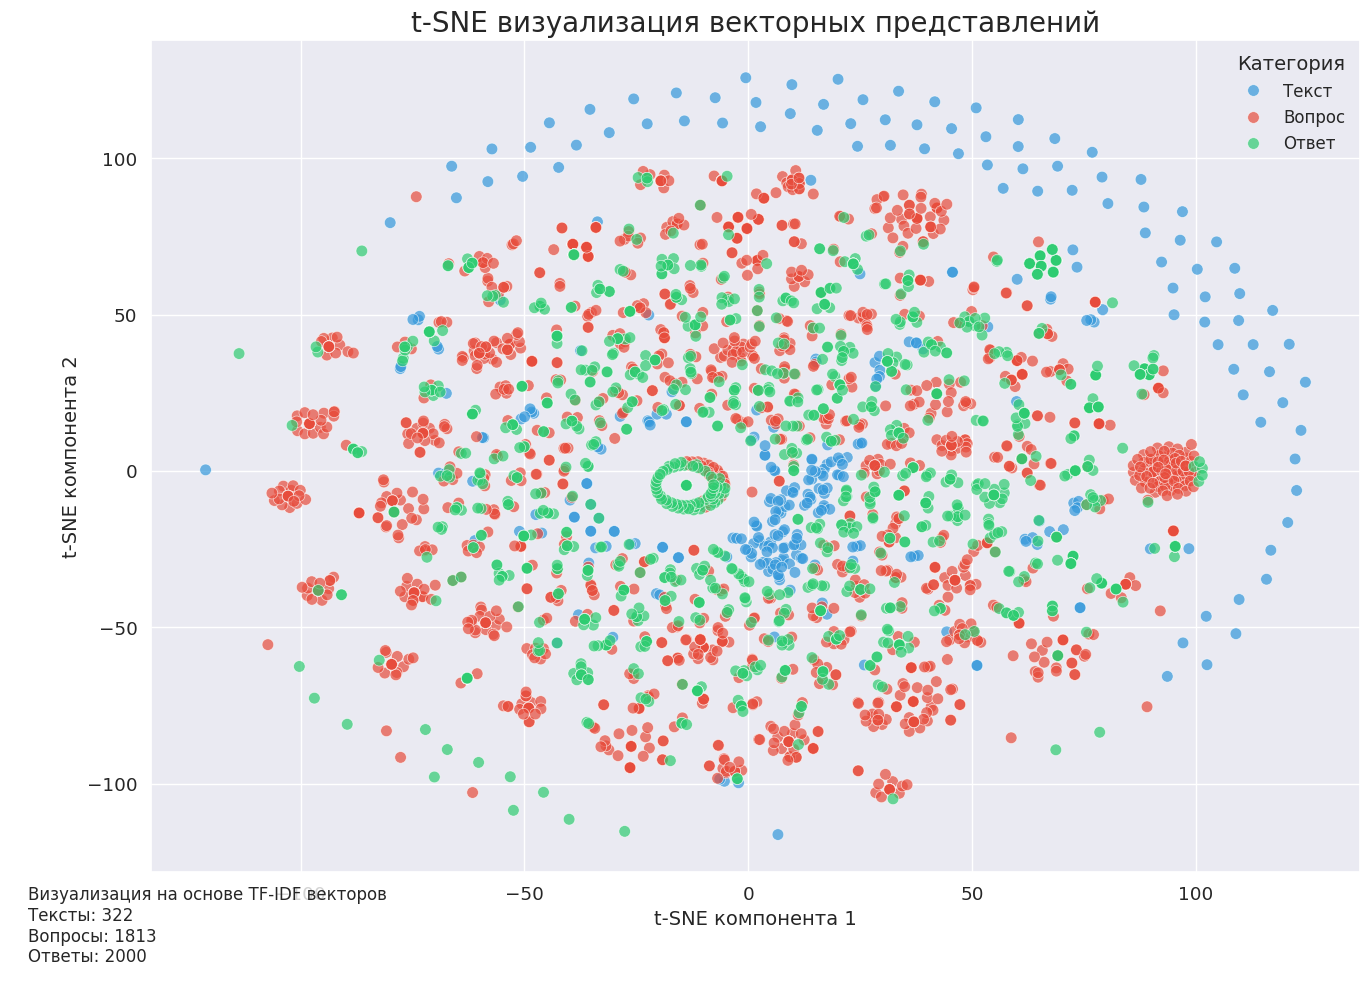

t-SNE визуализация создана!
<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>


In [146]:
print(tsne_visual(passages_test, questions_test, answers_test))

* Тексты (синие точки) образуют четкий внешний круг, что указывает на их значительное отличие от вопросов и ответов с точки зрения лексического состава и структуры


* Вопросы (красные точки) и ответы (зеленые точки) более перемешаны между собой и расположены ближе к центру визуализации


* Заметны кластеры вопросов и ответов, что может указывать на группы семантически похожих вопросов и ответов


* Некоторые вопросы и ответы расположены очень близко друг к другу, что свидетельствует об их высокой семантической близости


* В центре визуализации есть интересная круговая структура из зеленых точек (ответов)

Исходя из этих выводов можно сказать, что:

* Тексты документов значительно отличаются от вопросов и ответов по своим лексическим характеристикам

* Вопросы и ответы часто имеют сходную лексику, но всё же образуют различимые кластеры

* Существуют группы семантически схожих вопросов и ответов, что может быть полезно учитывать при разработке вопросно-ответной системы

# Гипотезы


1. Модели, использующие семантическую близость между вопросом и фрагментами текста, будут показывать лучшие результаты, чем модели, опирающиеся только на лексическое совпадение. Это подтверждается наблюдаемым в t-SNE визуализации перекрытием между вопросами и текстами.

2. Для корректного ответа на вопрос достаточно ограниченного контекста (2-3 предложения вокруг релевантной информации), а не всего документа.

3. Предварительная обработка данных (лемматизация, удаление стоп-слов) значительно улучшит качество извлечения ответов.

4. Модель основанная на трансфомере, как RuBERT, покажет более высокую точность и качество, чем классические модели как TF_IDF или "мешок слов", так как она имеет лучшее понимание контекста и лучше работает с семантическими связями.

# Метрики оценки качества

**F1-мера**: учитывает как количество правильно определенных положительных примеров, так и способность модели находить все положительные примеры. Также F1-мера оценивает качество модели при конкретном выбранном пороге принятия решения, что отражает реальную практическую эффективность системы.


**ROC AUC**: оценивает качество модели для всех возможных порогов принятия решения. Это позволяет понять, насколько хорошо модель ранжирует ответы независимо от выбранного порога. Также  ROC AUC показывает, насколько хорошо модель различает классы.

Для вопросно-ответной системы F1-мера оценивает практическую эффективность модели при фиксированном пороге, а ROC AUC оценивает способность модели ранжировать ответы во всем диапазоне порогов.

